# De novo structural variant identification from long-read sequencing of schistosome parasite populations

*Shalini Nair, Xue Li, Elisha Enabulele, Kathrin S. Jutzeler, Winka Le Clec’h, Frédéric D. Chevalier, Timothy J. C. Anderson, Roy N. Platt II*

Texas Biomedical Research Institute, San Antonio, Texas, USA

Fall 2024

__ABSTRACT__: Genetic diversity circulates in populations in multiple forms; from single nucleotide variants to genome duplications.  Often times, population genetic studies emphasize single nucleotide variants, small indels (≤50bp) occasionally, and neglect large structural variants (>50bp), despite the fact that structural variants often impact disproportionately large portions of the genome relative to their smaller counterparts.  Here, we examined large structural variants circulating in five lab populations of the human parasite Schistosoma mansoni by creating pools of worms (~100 per population) and generating long-read sequences.  Using this method, we were able identify and genotype 17,446 SVs, representing 6.5% of the genome despite challenges in identifying low frequency variants. More than half (59%) of the SVs were shared between ≥4 populations, but 12% of them were found in only one of the five populations.  Within this subset, we were able to identify 168 population-specific SVs that were at-or-near fixation in one population but missing (<5%) in the other four populations, and 5 of these variants directly impacted the coding sequence of 6 genes. We also identified 8 structural variants with extreme allele frequency differences between populations in genome regions associated with pathogen phenotypes. These results demonstrate that long-read sequence data from pooled individuals is a viable method to quickly catalogue structural variants circulating within a population and that a portion of these variants may be responsible for, or linked to regions experiencing, population-specific directional selection. 

# Prep. for data analyses

Basic prep. for analyses includes setting up dir structure, naming populations, importing python modules, etc.

In [45]:
import io
import os
from collections import defaultdict
from itertools import combinations
from pathlib import Path

import gffutils
import numpy as np
import pandas as pd
import vcf
import venn
from Bio import SeqIO
from intervaltree import IntervalTree
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

In [46]:
proj_dir = "/master/nplatt/sch_man_ont"
ref_fas = "{}/data/genome/SM_V10.fa".format(proj_dir)
Path("{}/results".format(proj_dir)).mkdir(parents=True, exist_ok=True)

In [47]:
samples = ["smbre", "smeg", "smle-pzq-er", "smle-pzq-es", "smor"]
pops = samples

In [48]:
os.chdir("{}/results".format(proj_dir))

# Combine Raw Long Reads into Populations

In some cases the long reads were seqeunced in multiple runs.  Here we combine reads from the same populations and standardize the names of the .fastq files for ease of use.

The raw data is from multiple sequencing runs and it is best/easisest if we combine it into a single file for downstream work.

In [5]:
Path("{}/results/raw_reads".format(proj_dir)).mkdir(parents=True, exist_ok=True)
os.chdir("{}/results/raw_reads".format(proj_dir))

In [ ]:
%%bash 

DATA=/master/nplatt/sch_man_ont/data

# smbre ----------------------
zcat $DATA/SmBRE_10182022/no_sample/20221018_1043_MC-110254_FAT94061_3be94c01/fastq_pass/FAT94061_pass_5e6aef65_*gz >smbre.fastq &
# ----------------------------

# smeg -----------------------
zcat $DATA/SmEG_2/no_sample/20221219_1251_MC-110254_FAV14922_3a8a2fa9/fastq_pass/FAV14922_pass_24ea1607_*gz \
     $DATA/SmEG_Female_6_02_22/no_sample/20220523_1102_MC-110254_FAT13494_c562973b/fastq_pass/FAT13494_pass_5a70f0ff_*.gz\
     >smeg.fastq &
#-----------------------------

# smle-pzq-er ----------------
zcat $DATA/V14_Smle_R/no_sample/20230105_1829_MC-110254_FAU92303_cc3e8354/fastq_pass/FAU92303_pass_cc3e8354_368dd688_*gz \
    >smle-pzq-er.fastq &
#-----------------------------

# smle-pzq-es ----------------
zcat $DATA/schisto_pairs_04132022/no_sample/20220413_1030_MC-110254_FAS57617_fdc4f280/fastq_pass/FAS57617_pass_f77dcaa6_*gz \
    $DATA/V14_Smle_S/no_sample/20230109_1649_MC-110254_FAV67293_20684beb/fastq_pass/FAV67293_pass_20684beb_b8e64529_*gz \
    $DATA/V14_Smle_S_2/no_sample/20230110_1931_MC-110254_FAV67293_70d56838/fastq_pass/FAV67293_pass_70d56838_f285c3d6_*gz \
    >smle-pzq-es.fastq &
#----------------------------

# smor ----------------------
zcat $DATA/SmOR_Female_5_25_22/no_sample/20220530_1011_MC-110254_FAT30731_19d6f87b/fastq_pass/FAT30731_pass_99b43000_*.gz >smor.fastq &
#----------------------------


# Process raw reads into SV genotypes

A snakemake script (`sch_man_ont/code/01-gt-svs.snk.py`) automates a pipeline to take raw fastq reads, de novo identify and filter SVS, merge them into a single catalogue and then re-genotype each population.  The output of this set of analysis is a table and/or VCF files that contain SV calls for each of the _S. mansoni_ populations. Those analyses are documented directly in that file.

In [ ]:
# snakemake
#     --printshellcmds
#     --cluster 'qsub -V -cwd -j y -S /bin/bash -pe smp {threads} -q all.q -o {log} '
#     --jobs 200
#     --latency-wait 200
#     --keep-going
#     --rerun-incomplete
#     --snake code/01-gt_svs.snk.py
#     --use-conda
#     --jobname snk.ONT.{name}.jid{jobid}

# [Table 1] Generate a table describing basic data from each sample

Here we make a table that summarizes data form each sample and includes things like N50, number of reads, genome coverage, mapping rate, number of SVS, etc.  This code generates most of the information presented in the basic summary table.

In [88]:
Path("{}/results/sample_summary_table".format(proj_dir)).mkdir(
    parents=True, exist_ok=True
)
os.chdir("{}/results/sample_summary_table".format(proj_dir))

In [89]:
raw_n50_df = pd.read_csv(f"../raw_reads/n50_raw_reads.csv", header=0, sep=",")
pops = [x.split("/")[6].replace(".fastq", "") for x in raw_n50_df["#path"]]
raw_n50_df["#path"] = pops
raw_n50_df = raw_n50_df.rename({"#path": "pop"}, axis=1)
cols = [f"{x}.raw" for x in raw_n50_df.columns]
raw_n50_df.columns = cols
raw_n50_df

,pop.raw,seqs.raw,size.raw,N50.raw,min.raw,max.raw,N75.raw,N90.raw,auN.raw
0,smbre,2757714,14071249606,15795,94,193119,7163,2248,370049.65
1,smeg,1696681,9490830960,13449,86,236992,6098,2704,276864.56
2,smle-pzq-es,3982589,22914921839,13044,33,198255,5555,2471,624451.87
3,smle-pzq-er,1707939,7212860476,11608,13,447404,4577,1795,237404.00
4,smor,4277708,14622901611,8232,92,168323,3171,1394,626721.58


In [90]:
filt_n50_df = pd.read_csv(f"../nanoq/n50_filtered_reads.csv", header=0, sep=",")
pops = [x.split("/")[6].replace(".nanoq.fastq", "") for x in filt_n50_df["#path"]]
filt_n50_df["#path"] = pops
filt_n50_df = filt_n50_df.rename({"#path": "pop"}, axis=1)
cols = [f"{x}.filt" for x in filt_n50_df.columns]
filt_n50_df.columns = cols
filt_n50_df

,pop.filt,seqs.filt,size.filt,N50.filt,min.filt,max.filt,N75.filt,N90.filt,auN.filt
0,smbre,2156891,13733527914,16145,500,193069,7657,2728,357349.74
1,smeg,1397888,9315645341,13681,500,236942,6337,2921,273369.67
2,smle-pzq-es,3558751,22574090671,13259,500,198205,5706,2592,615206.75
3,smle-pzq-er,1330051,7000372416,12071,500,447354,4953,2105,227185.13
4,smor,3413369,14119478724,8668,500,168273,3430,1618,598308.11


In [91]:
num_df = pd.merge(raw_n50_df, filt_n50_df, left_on="pop.raw", right_on="pop.filt")
num_df = num_df.rename({"pop.raw": "pop"}, axis=1)
num_df.drop("pop.filt", axis=1, inplace=True)
num_df

,pop,seqs.raw,size.raw,N50.raw,min.raw,max.raw,N75.raw,N90.raw,auN.raw,seqs.filt,size.filt,N50.filt,min.filt,max.filt,N75.filt,N90.filt,auN.filt
0,smbre,2757714,14071249606,15795,94,193119,7163,2248,370049.65,2156891,13733527914,16145,500,193069,7657,2728,357349.74
1,smeg,1696681,9490830960,13449,86,236992,6098,2704,276864.56,1397888,9315645341,13681,500,236942,6337,2921,273369.67
2,smle-pzq-es,3982589,22914921839,13044,33,198255,5555,2471,624451.87,3558751,22574090671,13259,500,198205,5706,2592,615206.75
3,smle-pzq-er,1707939,7212860476,11608,13,447404,4577,1795,237404.00,1330051,7000372416,12071,500,447354,4953,2105,227185.13
4,smor,4277708,14622901611,8232,92,168323,3171,1394,626721.58,3413369,14119478724,8668,500,168273,3430,1618,598308.11


In [92]:
cov_df = pd.read_csv("../mosdepth/covs.cvs", header=0, sep=",")
pops = [x.split("/")[6] for x in cov_df["sample"]]
cov_df["sample"] = pops
cov_df = cov_df.rename({"sample": "pop"}, axis=1)
cov_df.drop(["length", "min"], axis=1, inplace=True)

cov_df

,pop,bases,mean,max
0,smbre,12929852060,33.03,50203
1,smeg,8667206488,22.14,34244
2,smle-pzq-er,6624855708,16.93,10415
3,smle-pzq-es,19947686816,50.96,41164
4,smor,12178116550,31.11,79935


In [93]:
num_df = pd.merge(num_df, cov_df, on="pop")
num_df

,pop,seqs.raw,size.raw,N50.raw,min.raw,max.raw,N75.raw,N90.raw,auN.raw,seqs.filt,size.filt,N50.filt,min.filt,max.filt,N75.filt,N90.filt,auN.filt,bases,mean,max
0,smbre,2757714,14071249606,15795,94,193119,7163,2248,370049.65,2156891,13733527914,16145,500,193069,7657,2728,357349.74,12929852060,33.03,50203
1,smeg,1696681,9490830960,13449,86,236992,6098,2704,276864.56,1397888,9315645341,13681,500,236942,6337,2921,273369.67,8667206488,22.14,34244
2,smle-pzq-es,3982589,22914921839,13044,33,198255,5555,2471,624451.87,3558751,22574090671,13259,500,198205,5706,2592,615206.75,19947686816,50.96,41164
3,smle-pzq-er,1707939,7212860476,11608,13,447404,4577,1795,237404.00,1330051,7000372416,12071,500,447354,4953,2105,227185.13,6624855708,16.93,10415
4,smor,4277708,14622901611,8232,92,168323,3171,1394,626721.58,3413369,14119478724,8668,500,168273,3430,1618,598308.11,12178116550,31.11,79935


In [94]:
%%bash
cd ../minimap2/

echo pop,n_map,rate >mapping_rate.csv
grep "mapped" *.flagstats.txt | grep -v mate | grep -v primary | sed 's/:/,/' | cut -f1,5 -d" " | sed 's/ (/,/' | sed 's/.flagstats.txt//' >>mapping_rate.csv

In [95]:
map_df = pd.read_csv("../minimap2/mapping_rate.csv", header=0, sep=",")
map_df

,pop,n_map,rate
0,smbre,4609342,97.96%
1,smeg,2750312,98.25%
2,smle-pzq-er,2504219,97.52%
3,smle-pzq-es,6379565,93.52%
4,smor,5904396,90.33%


In [96]:
num_df = pd.merge(num_df, map_df, on="pop")
num_df

,pop,seqs.raw,size.raw,N50.raw,min.raw,max.raw,N75.raw,N90.raw,auN.raw,seqs.filt,...,min.filt,max.filt,N75.filt,N90.filt,auN.filt,bases,mean,max,n_map,rate
0,smbre,2757714,14071249606,15795,94,193119,7163,2248,370049.65,2156891,...,500,193069,7657,2728,357349.74,12929852060,33.03,50203,4609342,97.96%
1,smeg,1696681,9490830960,13449,86,236992,6098,2704,276864.56,1397888,...,500,236942,6337,2921,273369.67,8667206488,22.14,34244,2750312,98.25%
2,smle-pzq-es,3982589,22914921839,13044,33,198255,5555,2471,624451.87,3558751,...,500,198205,5706,2592,615206.75,19947686816,50.96,41164,6379565,93.52%
3,smle-pzq-er,1707939,7212860476,11608,13,447404,4577,1795,237404.00,1330051,...,500,447354,4953,2105,227185.13,6624855708,16.93,10415,2504219,97.52%
4,smor,4277708,14622901611,8232,92,168323,3171,1394,626721.58,3413369,...,500,168273,3430,1618,598308.11,12178116550,31.11,79935,5904396,90.33%


In [97]:
%%bash

cd ../cutesv/
echo pop,raw_svs_calls,filt_sv_calls >n_sv_calls.csv

for POP in smbre smeg smle-pzq-er smle-pzq-es smor; do
    RAW=$(grep -v "#" $POP.cutesv.vcf | wc -l)
    FILT=$(grep -v "#" $POP.cutesv.filtered.vcf | wc -l)
    echo $POP,$RAW,$FILT >>n_sv_calls.csv 
done 

In [98]:
n_sv_df = pd.read_csv("../cutesv/n_sv_calls.csv", header=0, sep=",")
num_df = pd.merge(num_df, n_sv_df, on="pop")
num_df

,pop,seqs.raw,size.raw,N50.raw,min.raw,max.raw,N75.raw,N90.raw,auN.raw,seqs.filt,...,N75.filt,N90.filt,auN.filt,bases,mean,max,n_map,rate,raw_svs_calls,filt_sv_calls
0,smbre,2757714,14071249606,15795,94,193119,7163,2248,370049.65,2156891,...,7657,2728,357349.74,12929852060,33.03,50203,4609342,97.96%,34806,15039
1,smeg,1696681,9490830960,13449,86,236992,6098,2704,276864.56,1397888,...,6337,2921,273369.67,8667206488,22.14,34244,2750312,98.25%,23476,6728
2,smle-pzq-es,3982589,22914921839,13044,33,198255,5555,2471,624451.87,3558751,...,5706,2592,615206.75,19947686816,50.96,41164,6379565,93.52%,44036,15921
3,smle-pzq-er,1707939,7212860476,11608,13,447404,4577,1795,237404.00,1330051,...,4953,2105,227185.13,6624855708,16.93,10415,2504219,97.52%,19884,5023
4,smor,4277708,14622901611,8232,92,168323,3171,1394,626721.58,3413369,...,3430,1618,598308.11,12178116550,31.11,79935,5904396,90.33%,31631,13579


In [99]:
safe_df = num_df.copy()

In [100]:
num_df = safe_df.copy()

In [101]:
cols_to_keep = [
    "pop",
    "seqs.filt",
    "size.filt",
    "N50.filt",
    "max.filt",
    "rate",
    "mean",
    "raw_svs_calls",
    "filt_sv_calls",
]

num_df = num_df[cols_to_keep]

col_names = {
    "pop": "Population",
    "seqs.filt": "Num. Filt. Reads (1e6)",
    "size.filt": "Num. Filt. Bases (Gb)",
    "N50.filt": "N50 Filt. Reads (bp)",
    "max.filt": "Max Filt. Read Len. (Kb)",
    "mean": "Mean Genome Cov",
    "rate": "Read Mapping Rate",
    "raw_svs_calls": "Num. Raw SV Calls",
    "filt_sv_calls": "Num. Filt. SV Calls",
}

num_df = num_df.rename(col_names, axis=1)
real_pops = ["SmBre", "SmEG", "SmLE-PZQ-ES", "SmLE-PZQ-ER", "SmOR"]
num_df["Population"] = real_pops

num_df["Num. Filt. Reads (1e6)"] = [
    f"{x/1_000_000:.2f}" for x in num_df["Num. Filt. Reads (1e6)"]
]
num_df["Num. Filt. Bases (Gb)"] = [
    f"{x/1_000_000_000:.2f}" for x in num_df["Num. Filt. Bases (Gb)"]
]
num_df["Max Filt. Read Len. (Kb)"] = [
    f"{x/1_000:.2f}" for x in num_df["Max Filt. Read Len. (Kb)"]
]


num_df

,Population,Num. Filt. Reads (1e6),Num. Filt. Bases (Gb),N50 Filt. Reads (bp),Max Filt. Read Len. (Kb),Read Mapping Rate,Mean Genome Cov,Num. Raw SV Calls,Num. Filt. SV Calls
0,SmBre,2.16,13.73,16145,193.07,97.96%,33.03,34806,15039
1,SmEG,1.40,9.32,13681,236.94,98.25%,22.14,23476,6728
2,SmLE-PZQ-ES,3.56,22.57,13259,198.21,93.52%,50.96,44036,15921
3,SmLE-PZQ-ER,1.33,7.00,12071,447.35,97.52%,16.93,19884,5023
4,SmOR,3.41,14.12,8668,168.27,90.33%,31.11,31631,13579


In [ ]:
%%bash
echo sample,longest_mapped>longest_map.csv

for POP in smbre smeg smle-pzq-er smle-pzq-es smor; do
    LONGEST=$(conda run -n samtools samtools view -F 4 ../minimap2/$POP.bam | awk '{print length($10), $1}' | sort -nr | head -1)
    
    echo $POP,$LONGEST>>longest_map.csv 
done 

In [136]:
num_df.to_csv("../figures_and_tables/basic_sequence_stats_per_population.csv", sep=",", header=True, index=False)

In [97]:
# size of sv variants
# grep -v "#" survivor.vcf  | cut -f3 -d";" | cut -f2 -d"=" | sed s'/-//' | awk '{SUM+=$1} END {print SUM}'
(14200651 / 397918904) * 100

3.5687299239243986

In [103]:
num_df = pd.read_csv("../figures_and_tables/basic_sequence_stats_per_population.csv", sep=",", header=0)
num_df.head()

,Population,Num. Filt. Reads (1e6),Num. Filt. Bases (Gb),N50 Filt. Reads (bp),Max Filt. Read Len. (Kb),Read Mapping Rate,Mean Genome Cov,Num. Raw SV Calls,Num. Filt. SV Calls
0,SmBre,2.16,13.73,16145,193.07,97.96%,33.03,34806,15039
1,SmEG,1.40,9.32,13681,236.94,98.25%,22.14,23476,6728
2,SmLE-PZQ-ES,3.56,22.57,13259,198.21,93.52%,50.96,44036,15921
3,SmLE-PZQ-ER,1.33,7.00,12071,447.35,97.52%,16.93,19884,5023
4,SmOR,3.41,14.12,8668,168.27,90.33%,31.11,31631,13579


# [Supplemental Figure 1] Genome Coverage vs. the Number of SV calls

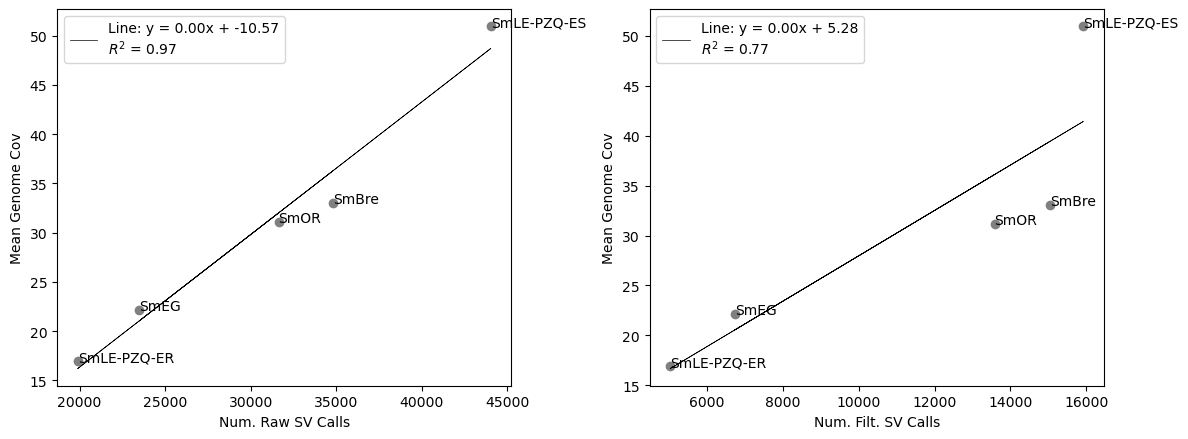

In [135]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

os.chdir("{}/results/sample_summary_table".format(proj_dir))

num_df = pd.read_csv("../figures_and_tables/basic_sequence_stats_per_population.csv", sep=",", header=0)
num_df.head()

# Data for first scatter plot
x1 = num_df["Num. Raw SV Calls"]
y1 = num_df["Mean Genome Cov"]

# Data for second scatter plot
x2 = num_df["Num. Filt. SV Calls"]
y2 = num_df["Mean Genome Cov"]

# Perform linear regression for the first dataset
slope1, intercept1, r_value1, _, _ = linregress(x1, y1)
r2_1 = r_value1**2  # Calculate R^2 for the first regression

# Perform linear regression for the second dataset
slope2, intercept2, r_value2, _, _ = linregress(x2, y2)
r2_2 = r_value2**2  # Calculate R^2 for the second regression

# Plotting the data and the regression lines
fig, axs = plt.subplots(1, 2, figsize=(12, 4.5))

# First scatter plot
axs[0].scatter(x1, y1, color='grey')
# axs[0].set_title("Num. Raw SV Calls vs Mean Genome Cov")
axs[0].set_xlabel("Num. Raw SV Calls")
axs[0].set_ylabel("Mean Genome Cov")

# Add text labels for each point in the first plot
for i in range(num_df.shape[0]):
    axs[0].text(x1.iloc[i], y1.iloc[i], num_df["Population"].iloc[i], size=10)

# Plot regression line for the first dataset
axs[0].plot(x1, slope1 * x1 + intercept1, color='black', linewidth=0.5, label=f'Line: y = {slope1:.2f}x + {intercept1:.2f}\n$R^2$ = {r2_1:.2f}')
axs[0].legend()

# Second scatter plot
axs[1].scatter(x2, y2, color='grey')
# axs[1].set_title("Num. Filt. SV Calls vs Mean Genome Cov")
axs[1].set_xlabel("Num. Filt. SV Calls")
axs[1].set_ylabel("Mean Genome Cov")

# Add text labels for each point in the second plot
for i in range(num_df.shape[0]):
    axs[1].text(x2.iloc[i], y2.iloc[i], num_df["Population"].iloc[i], size=10)

# Plot regression line for the second dataset
axs[1].plot(x2, slope2 * x2 + intercept2, color='black', linewidth=0.5, label=f'Line: y = {slope2:.2f}x + {intercept2:.2f}\n$R^2$ = {r2_2:.2f}')
axs[1].legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Save plot
plt.savefig("../figures_and_tables/coverage_vs_sv_calls.png", format="png", dpi=600, facecolor="white")
plt.savefig("../figures_and_tables/coverage_vs_sv_calls.svg", facecolor="white")

# Show the plot
plt.show()


# Which de novo SVs (CuteSV) were filtered

Within the snakemake script, we use CuteSV to identify SVs for each population.  Many of those calls end up being filtered out.  This code examines the cuteSV vcfs along with quality metrics like QUAL and GQ to understand why variants were removed.

In [219]:
os.chdir("{}/results/cutesv".format(proj_dir))

In [324]:
import vcf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# List of your VCF files for different populations
vcf_files = {
    "smbre": "smbre.cutesv.vcf",
    "smeg": "smeg.cutesv.vcf",
    "smle-pzq-er": "smle-pzq-er.cutesv.vcf",
    "smle-pzq-es": "smle-pzq-es.cutesv.vcf",
    "smor": "smor.cutesv.vcf"
}

# Initialize a DataFrame to store all data
combined_df = pd.DataFrame()

# Loop through each population VCF file
for population, vcf_file in vcf_files.items():
    # Read the VCF file
    vcf_reader = vcf.Reader(open(vcf_file, 'r'))
    
    # Initialize lists to store the data for this population
    svtypes = []
    qual_scores = []
    allele_frequencies = []
    gqs = []
    ref_depths = []
    var_depths = []
    
    # Loop through each record in the VCF
    for record in vcf_reader:
        svtypes.append(record.INFO.get('SVTYPE', 'NA'))  # Use 'NA' if SVTYPE is not available
        qual_scores.append(record.QUAL)
        
        # Assuming the allele frequency is stored in the INFO field under 'AF' or similar key
        af = record.INFO.get('AF', [None])[0]
        allele_frequencies.append(af)

        # Extract GQ, DR (reference depth), and DV (variant depth) from the first sample
        if len(record.samples) > 0:
            sample = record.samples[0]
            gq = sample['GQ']
            dr = sample['DR']  # Reference depth
            dv = sample['DV']  # Variant depth

            gqs.append(gq)
            ref_depths.append(dr)
            var_depths.append(dv)
        else:
            gqs.append(None)
            ref_depths.append(None)
            var_depths.append(None)
    
    # Create a DataFrame from the extracted data
    df = pd.DataFrame({
        'svtype': svtypes,
        'QUAL': qual_scores,
        'Allele Frequency': allele_frequencies,
        'GQ': gqs,
        'Ref Depth': ref_depths,
        'Var Depth': var_depths
    })
    
    # Drop rows where Allele Frequency or GQ is None (if any)
    df = df.dropna(subset=['Allele Frequency', 'GQ'])
    
    # Add a column for population
    df['Population'] = population
    
    # Append the data to the combined DataFrame
    combined_df = pd.concat([combined_df, df], ignore_index=True)

# Display the combined DataFrame
combined_df.head()  # Display the first few rows of the combined DataFrame

,svtype,QUAL,Allele Frequency,GQ,Ref Depth,Var Depth,Population
0,INS,24.1,0.4615,23.0,7.0,6,smbre
1,INS,43.0,0.7000,4.0,3.0,7,smbre
2,DEL,0.1,0.1923,18.0,21.0,5,smbre
3,INS,267.2,0.9118,58.0,3.0,31,smbre
4,INS,0.1,0.2222,15.0,28.0,8,smbre


In [325]:
combined_df["DP"] = combined_df["Ref Depth"] + combined_df["Var Depth"]

In [326]:
# Assuming 'df' is your DataFrame and contains the columns 'Allele Frequency' and 'GQ'

# Bin the allele frequencies
bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
combined_df['AF_Bin'] = pd.cut(combined_df['Allele Frequency'], bins=bins)
combined_df

,svtype,QUAL,Allele Frequency,GQ,Ref Depth,Var Depth,Population,DP,AF_Bin
0,INS,24.1,0.4615,23.0,7.0,6,smbre,13.0,"(0.4, 0.5]"
1,INS,43.0,0.7000,4.0,3.0,7,smbre,10.0,"(0.6, 0.7]"
2,DEL,0.1,0.1923,18.0,21.0,5,smbre,26.0,"(0.1, 0.2]"
3,INS,267.2,0.9118,58.0,3.0,31,smbre,34.0,"(0.9, 1.0]"
4,INS,0.1,0.2222,15.0,28.0,8,smbre,36.0,"(0.2, 0.3]"
...,...,...,...,...,...,...,...,...,...
153814,DEL,66.4,0.4222,66.0,26.0,19,smor,45.0,"(0.4, 0.5]"
153815,DEL,0.3,0.2222,11.0,21.0,6,smor,27.0,"(0.2, 0.3]"
153816,DEL,99.0,0.7273,3.0,6.0,16,smor,22.0,"(0.7, 0.8]"
153817,INS,219.5,0.9259,49.0,2.0,25,smor,27.0,"(0.9, 1.0]"


In [297]:
# Calculate the median GQ for each AF_Bin
median_gq_by_bin = combined_df.groupby('AF_Bin')['GQ'].median().reset_index()

# Display the resulting table
print(median_gq_by_bin)

       AF_Bin     GQ
0  (0.0, 0.1]  103.0
1  (0.1, 0.2]   45.0
2  (0.2, 0.3]    7.0
3  (0.3, 0.4]   19.0
4  (0.4, 0.5]   39.0
5  (0.5, 0.6]   37.0
6  (0.6, 0.7]   16.0
7  (0.7, 0.8]    6.0
8  (0.8, 0.9]   26.0
9  (0.9, 1.0]   51.0


/tmp/ipykernel_5996/698509321.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([f'{int(bin.left*100)}-{int(bin.right*100)}%' for bin in combined_df['AF_Bin'].cat.categories])


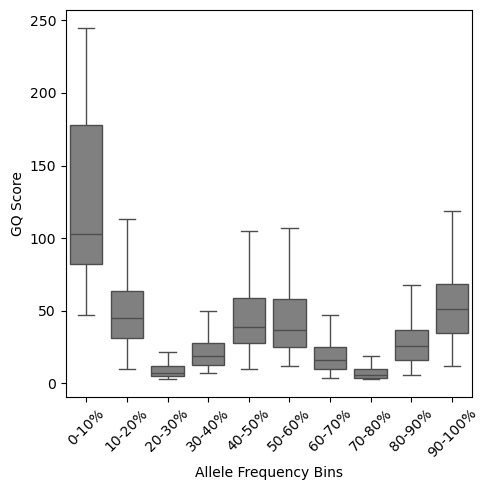

In [300]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create the boxplot without fliers
plt.figure(figsize=(5, 5))
ax = sns.boxplot(x='AF_Bin', y='GQ', data=combined_df, showfliers=False, color="grey")

# Clean up x-axis labels
ax.set_xticklabels([f'{int(bin.left*100)}-{int(bin.right*100)}%' for bin in combined_df['AF_Bin'].cat.categories])

plt.xlabel('Allele Frequency Bins')
plt.ylabel('GQ Score')
# plt.title('GQ Scores Across Allele Frequency Bins')
plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig("../figures_and_tables/gq_vs_af_all_svs.png", format="png", dpi=600, facecolor="white")
plt.savefig("../figures_and_tables/gq_vs_af_all_svs.svg", facecolor="white")


plt.show()


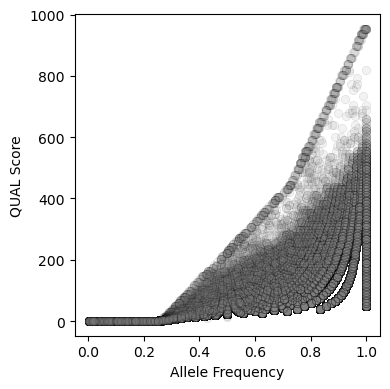

In [301]:
# Plot AF vs QUAL for all populations in grey with alpha
plt.figure(figsize=(4, 4))
sns.scatterplot(
    x='Allele Frequency', 
    y='QUAL', 
    data=combined_df, 
    color='grey',  # All points in grey
    alpha=0.1,  # Transparency for points
    edgecolor="black"
)
plt.xlabel('Allele Frequency')
plt.ylabel('QUAL Score')
plt.tight_layout()

plt.savefig("../figures_and_tables/qual_vs_af_all_svs.png", format="png", dpi=600, facecolor="white")
plt.savefig("../figures_and_tables/qual_vs_af_all_svs.svg", facecolor="white")


plt.show()

In [ ]:
# # Perform linear regression with intercept set to 0
# X = combined_df['Allele Frequency']
# y = combined_df['QUAL']
# X = sm.add_constant(X, has_constant='add')  # Only adds a constant if there isn't one, needed for statsmodels

# # Perform OLS regression without intercept
# model = sm.OLS(y, X[:, 1], hasconst=False).fit()  # X[:, 1] excludes the constant

# # Plot the regression line with intercept 0
# plt.figure(figsize=(10, 6))
# sns.scatterplot(x='Allele Frequency', y='QUAL', data=combined_df, alpha=0.5)
# plt.plot(X[:, 1], model.fittedvalues, color='red', label=f'Fit: y = {model.params[0]:.2f}x')
# plt.xlabel('Allele Frequency')
# plt.ylabel('QUAL Score')
# plt.title('Regression of QUAL Score vs. Allele Frequency with Intercept = 0')
# plt.legend()
# plt.show()

# # Calculate the correlation between QUAL score and Allele Frequency
# correlation, p_value = pearsonr(df['Allele Frequency'], df['QUAL'])
# print(f"Pearson correlation: {correlation:.2f}, P-value: {p_value:.2e}")

In [332]:
combined_df["Population"].value_counts()

Population
smle-pzq-es    44031
smbre          34805
smor           31624
smeg           23475
smle-pzq-er    19884
Name: count, dtype: int64

In [335]:
combined_df.loc[combined_df["DP"] < 10, "Population"].value_counts()

Population
smle-pzq-er    2095
smor            876
smbre           801
smeg            799
smle-pzq-es     250
Name: count, dtype: int64

In [342]:
len(combined_df.loc[combined_df["DP"] < 10])

4821

In [336]:
2095/combined_df.loc[combined_df["DP"] < 10, "Population"].value_counts().sum()

0.4345571458203692

In [320]:
len(combined_df.loc[combined_df["QUAL"] < 10])

44844

In [317]:
len(combined_df.loc[combined_df["QUAL"] < 10])/len(combined_df)

0.2915374563610477

In [318]:
combined_df.loc[combined_df["QUAL"] < 10, ["Allele Frequency"]].max()

Allele Frequency    0.3333
dtype: float64

In [319]:
combined_df.loc[combined_df["QUAL"] > 10, ["Allele Frequency"]].min()

Allele Frequency    0.2703
dtype: float64

In [343]:
# List of your VCF files for different populations
vcf_files = {
    "smbre": "smbre.cutesv.filtered.vcf",
    "smeg": "smeg.cutesv.filtered.vcf",
    "smle-pzq-er": "smle-pzq-er.cutesv.filtered.vcf",
    "smle-pzq-es": "smle-pzq-es.cutesv.filtered.vcf",
    "smor": "smor.cutesv.filtered.vcf"
}

# Initialize a DataFrame to store all data
filtered_df = pd.DataFrame()

# Loop through each population VCF file
for population, vcf_file in vcf_files.items():
    # Read the VCF file
    vcf_reader = vcf.Reader(open(vcf_file, 'r'))
    
    # Initialize lists to store the data for this population
    svtypes = []
    qual_scores = []
    allele_frequencies = []
    gqs = []
    ref_depths = []
    var_depths = []
    
    # Loop through each record in the VCF
    for record in vcf_reader:
        svtypes.append(record.INFO.get('SVTYPE', 'NA'))  # Use 'NA' if SVTYPE is not available
        qual_scores.append(record.QUAL)
        
        # Assuming the allele frequency is stored in the INFO field under 'AF' or similar key
        af = record.INFO.get('AF', [None])[0]
        allele_frequencies.append(af)

        # Extract GQ, DR (reference depth), and DV (variant depth) from the first sample
        if len(record.samples) > 0:
            sample = record.samples[0]
            gq = sample['GQ']
            dr = sample['DR']  # Reference depth
            dv = sample['DV']  # Variant depth

            gqs.append(gq)
            ref_depths.append(dr)
            var_depths.append(dv)
        else:
            gqs.append(None)
            ref_depths.append(None)
            var_depths.append(None)
    
    # Create a DataFrame from the extracted data
    df = pd.DataFrame({
        'svtype': svtypes,
        'QUAL': qual_scores,
        'Allele Frequency': allele_frequencies,
        'GQ': gqs,
        'Ref Depth': ref_depths,
        'Var Depth': var_depths
    })
    
    # Drop rows where Allele Frequency or GQ is None (if any)
    df = df.dropna(subset=['Allele Frequency', 'GQ'])
    
    # Add a column for population
    df['Population'] = population
    
    # Append the data to the combined DataFrame
    filtered_df = pd.concat([filtered_df, df], ignore_index=True)

# Display the combined DataFrame
filtered_df

,svtype,QUAL,Allele Frequency,GQ,Ref Depth,Var Depth,Population
0,INS,24.1,0.4615,23,7,6,smbre
1,INS,43.0,0.7000,4,3,7,smbre
2,INS,267.2,0.9118,58,3,31,smbre
3,INS,238.6,1.0000,63,0,25,smbre
4,DEL,39.2,0.8333,6,1,5,smbre
...,...,...,...,...,...,...,...
108970,INS,53.8,0.4286,53,20,15,smor
108971,DEL,32.7,0.3404,32,31,16,smor
108972,DEL,66.4,0.4222,66,26,19,smor
108973,DEL,99.0,0.7273,3,6,16,smor


In [344]:
1-(len(filtered_df)/len(combined_df))

0.2915374563610478

In [350]:
filtered_df["Allele Frequency"].mean()

0.6627926221610462

# Convert SVJedi VCFs to tables/DataFrames

The output of the snake `01-gt-svs.snk.py` are tsv tables from SVJEDI.  Here we combine those tables and add relevant information from the genome annotation.  Addiontionally we use basic data explo to better understand the results at a course level before more detailed analyses.

The end result sof these analyses are three tables:

1) df - saved as `merged_jedi.csv` contains the SVs and relevant info (~17.5K entries)
2) all_gtf_df - saved as `all_svs_vs_genes.csv` contains the genes intersecting the SVS (~300K entries)
3) merged_df  - saved as `merged_jedi_gtf.csv` combines the two datasets and contins all the SV info (ex. AF) and intersecting genes per SV

In [49]:
Path(f"{proj_dir}/results/process_sv_tables").mkdir(parents=True, exist_ok=True)
os.chdir(f"{proj_dir}/results/process_sv_tables")

## SV DataFrame

To make the table we first convert each of the SVJedi .VCF files into TSVs and extract the select information.  Those TSVs are then merged into a single DF containing all variants and the relevant info for each population.  This is stored as `~/sch_man_ont/results/process_sv_tables/merged_jedi.tsv`

In [50]:
%%bash

for POP in smeg smbre smor smle-pzq-er smle-pzq-es; do
    echo -e "chrom\tpos\tend\tid\tciend\tsvlen\tsvtype\t${POP}.gt\t${POP}.dp\t${POP}.ad\t${POP}.pl" >${POP}.jedi_genotype.tsv
    conda run -n bcftools --cwd . --live-stream bcftools query --format "%CHROM\t%POS\t%END\t%ID\t%CIEND\t%SVLEN\t%SVTYPE\t[%GT\t%DP\t%AD\t%PL]\n" ../svjedi/${POP}.jedi_genotype.vcf >>${POP}.jedi_genotype.tsv
done

[W::bcf_hdr_check_sanity] PL should be declared as Number=G
[W::vcf_parse_info] INFO/END=180949 is smaller than POS at SM_V10_1:760792
[W::bcf_hdr_check_sanity] PL should be declared as Number=G
[W::vcf_parse_info] INFO/END=180949 is smaller than POS at SM_V10_1:760792
[W::bcf_hdr_check_sanity] PL should be declared as Number=G
[W::vcf_parse_info] INFO/END=180949 is smaller than POS at SM_V10_1:760792
[W::bcf_hdr_check_sanity] PL should be declared as Number=G
[W::vcf_parse_info] INFO/END=180949 is smaller than POS at SM_V10_1:760792
[W::bcf_hdr_check_sanity] PL should be declared as Number=G
[W::vcf_parse_info] INFO/END=180949 is smaller than POS at SM_V10_1:760792


In [51]:
eg_df = pd.read_csv("smeg.jedi_genotype.tsv", sep="\t", header=0)
bre_df = pd.read_csv("smbre.jedi_genotype.tsv", sep="\t", header=0)
er_df = pd.read_csv("smle-pzq-er.jedi_genotype.tsv", sep="\t", header=0)
es_df = pd.read_csv("smle-pzq-es.jedi_genotype.tsv", sep="\t", header=0)
or_df = pd.read_csv("smor.jedi_genotype.tsv", sep="\t", header=0)

or_df.head()

,chrom,pos,end,id,ciend,svlen,svtype,smor.gt,smor.dp,smor.ad,smor.pl
0,SM_V10_1,12381,19783898,cuteSV.BND.1,"0,0",0,TRA,./.,0.0,"0,0",".,.,."
1,SM_V10_1,13412,14879,cuteSV.DEL.0,"0,0",-1467,DEL,0/1,244.0,"30,214","8820,350,906"
2,SM_V10_1,13414,19782952,cuteSV.BND.2,"0,0",0,TRA,./.,0.0,"0,0",".,.,."
3,SM_V10_1,14246,14830,cuteSV.DEL.0,"0,0",-584,DEL,0/1,30.0,"4,26","1073,45,127"
4,SM_V10_1,15040,15637,cuteSV.DEL.1,"0,0",-597,DEL,0/1,244.0,"130,114","4183,15,4872"


In [52]:
#Before combining the SVjedi TSVs/DFs we make sure they are all the same size

if len(eg_df) == len(bre_df) == len(er_df) == len(es_df) == len(or_df):
    print(f"All dfs are the same size (n={len(eg_df)}): PROCEED")
else:
    print(f"The DFs from SVJedi vary in size")
    print(f"SmEG: {len(eg_df)}")
    print(f"SmOR: {len(or_df)}")
    print(f"SmBRE: {len(bre_df)}")
    print(f"SmLE-PZQ-ER: {len(er_df)}")
    print(f"SmLE-PZQ-Es: {len(es_df)}")


All dfs are the same size (n=17565): PROCEED


In [53]:
df = pd.concat(
    [
        eg_df,
        bre_df.iloc[:, -4:],
        er_df.iloc[:, -4:],
        es_df.iloc[:, -4:],
        or_df.iloc[:, -4:],
    ],
    axis=1,
)

for pop in ["smbre", "smle-pzq-er", "smle-pzq-es", "smeg", "smor"]:
    dps = df[f"{pop}.ad"].str.split(",", expand=True).astype(float)
    afs = dps[1] / (dps[0] + dps[1])

    df[f"{pop}.af"] = afs

# df = df.drop_duplicates(subset="id")
df = df.drop_duplicates(subset=["chrom", "pos"]).reset_index(drop=True)

# add unique names to each variant
ids = [f"{z}-{x}:{y}" for x, y, z in zip(df["chrom"], df["pos"], df["svtype"])]
df["sv_id"] = ids

df.to_csv("merged_jedi.csv", sep=",", header=True, index=False)
df

,chrom,pos,end,id,ciend,svlen,svtype,smeg.gt,smeg.dp,smeg.ad,...,smor.gt,smor.dp,smor.ad,smor.pl,smbre.af,smle-pzq-er.af,smle-pzq-es.af,smeg.af,smor.af,sv_id
0,SM_V10_1,12381,19783898,cuteSV.BND.1,"0,0",0,TRA,./.,0.0,"0,0",...,./.,0.0,"0,0",".,.,.",NaN,NaN,NaN,NaN,NaN,TRA-SM_V10_1:12381
1,SM_V10_1,13412,14879,cuteSV.DEL.0,"0,0",-1467,DEL,0/1,114.0,"20,94",...,0/1,244.0,"30,214","8820,350,906",NaN,0.830769,0.803279,0.824561,0.877049,DEL-SM_V10_1:13412
2,SM_V10_1,13414,19782952,cuteSV.BND.2,"0,0",0,TRA,./.,0.0,"0,0",...,./.,0.0,"0,0",".,.,.",NaN,NaN,NaN,NaN,NaN,TRA-SM_V10_1:13414
3,SM_V10_1,14246,14830,cuteSV.DEL.0,"0,0",-584,DEL,0/1,20.0,"6,14",...,0/1,30.0,"4,26","1073,45,127",NaN,0.818182,0.683333,0.700000,0.866667,DEL-SM_V10_1:14246
4,SM_V10_1,15040,15637,cuteSV.DEL.1,"0,0",-597,DEL,0/1,114.5,"59.5,55",...,0/1,244.0,"130,114","4183,15,4872",NaN,0.523077,0.495082,0.480349,0.467213,DEL-SM_V10_1:15040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17441,SM_V10_Z,86680808,86682886,cuteSV.DEL.16745,"0,0",-2078,DEL,0/1,2.5,"1.5,1",...,0/1,8.5,"5.5,3","109,6,217",0.200000,0.000000,0.210526,0.400000,0.352941,DEL-SM_V10_Z:86680808
17442,SM_V10_Z,86683524,86683767,cuteSV.DEL.23672,"0,0",-243,DEL,0/1,2.0,"1,1",...,0/1,6.0,"3,3","116,5,116",0.285714,0.000000,0.125000,0.500000,0.500000,DEL-SM_V10_Z:86683524
17443,SM_V10_Z,86685424,86685424,cuteSV.INS.16598,"0,0",827,INS,0/1,3.0,"2,1",...,0/1,5.0,"4,1","36,8,165",0.300000,0.000000,0.111111,0.333333,0.200000,INS-SM_V10_Z:86685424
17444,SM_V10_Z,86685725,86685725,cuteSV.INS.16599,"0,0",353,INS,0/1,3.0,"2,1",...,0/1,6.5,"3,3.5","135,4,113",0.500000,0.000000,0.250000,0.333333,0.538462,INS-SM_V10_Z:86685725


## SVs overlapping Genes DataFrame

One thing we will be interested in is finding genes that are impacted by SVs, to generate this table we first need to convert the SVs to beds, intersect them with a gene annotation file, then process the intersection in a way that is useful downstream.

For the genome annotation we use `/home/nplatt/sch_man_ont/data/genome/SM_V10.gtf` a file that can be accessed via Wormbase

In [54]:
bed_df = df[["chrom", "pos", "end", "sv_id"]]
df[["chrom", "pos", "end", "sv_id"]].to_csv("all_svs.bed", sep="\t", header=False, index=False)

bed_df.head()

,chrom,pos,end,sv_id
0,SM_V10_1,12381,19783898,TRA-SM_V10_1:12381
1,SM_V10_1,13412,14879,DEL-SM_V10_1:13412
2,SM_V10_1,13414,19782952,TRA-SM_V10_1:13414
3,SM_V10_1,14246,14830,DEL-SM_V10_1:14246
4,SM_V10_1,15040,15637,DEL-SM_V10_1:15040


In [57]:
%%bash 

conda run --live-stream -n bedtools bedtools intersect -wo -a all_svs.bed -b /master/nplatt/sch_man_ont/data/genome/SM_V10.gtf >all_svs_vs_genes.bed

One of the quirks of this analysis is that each SV may impact multiple genes and genes have multipl GTF features (gene, transcript, exon, cds, etc). As a results, ~17.5K SVs intersect with nearly 300K geneic features; Each SV is represented multiple times.  Rather than trying to process this into the merged_sv table from above, it is easier to use this table seperatley and then query between them using standardized `sv_id` column/field.

In [58]:
#read in the SV/gene intersection file
all_gtf_df = pd.read_csv("all_svs_vs_genes.bed", sep="\t", header=None)

#update the columns with useable names
all_gtf_df.columns = ["chrom",         "start",      "end",         "sv_id", 
                      "gtf_chrom",     "gtf_source", "gtf_feature", "gtf_start", 
                      "gtf_end",       "gtf_score",  "gtf_strand",  "gtf_frame", 
                      "gtf_attribute", "bp_overlap"]

#add a cleaned up gene name to each entry
all_gtf_df["gene"] = [x.split(";")[0].replace("gene_id \"", "").replace("\"", "") for x in all_gtf_df["gtf_attribute"]]    

#save a copy of the updated file
all_gtf_df.to_csv("all_svs_vs_genes.csv", sep=",", header=True, index=False)

all_gtf_df

,chrom,start,end,sv_id,gtf_chrom,gtf_source,gtf_feature,gtf_start,gtf_end,gtf_score,gtf_strand,gtf_frame,gtf_attribute,bp_overlap,gene
0,SM_V10_1,12381,19783898,TRA-SM_V10_1:12381,SM_V10_1,WormBase,gene,68427,68783,.,-,.,"gene_id ""Smp_329140""; gene_version ""1""; gene_s...",357,Smp_329140
1,SM_V10_1,12381,19783898,TRA-SM_V10_1:12381,SM_V10_1,WormBase,transcript,68427,68783,.,-,.,"gene_id ""Smp_329140""; gene_version ""1""; transc...",357,Smp_329140
2,SM_V10_1,12381,19783898,TRA-SM_V10_1:12381,SM_V10_1,WormBase,exon,68427,68783,.,-,.,"gene_id ""Smp_329140""; gene_version ""1""; transc...",357,Smp_329140
3,SM_V10_1,12381,19783898,TRA-SM_V10_1:12381,SM_V10_1,WormBase,CDS,68596,68763,.,-,0,"gene_id ""Smp_329140""; gene_version ""1""; transc...",168,Smp_329140
4,SM_V10_1,12381,19783898,TRA-SM_V10_1:12381,SM_V10_1,WormBase,start_codon,68761,68763,.,-,0,"gene_id ""Smp_329140""; gene_version ""1""; transc...",3,Smp_329140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299505,SM_V10_Z,86349025,86349025,INS-SM_V10_Z:86349025,SM_V10_Z,WormBase,transcript,86307894,86353135,.,+,.,"gene_id ""Smp_052630""; gene_version ""1""; transc...",0,Smp_052630
299506,SM_V10_Z,86350934,86350934,INS-SM_V10_Z:86350934,SM_V10_Z,WormBase,gene,86307894,86353135,.,+,.,"gene_id ""Smp_052630""; gene_version ""1""; gene_s...",0,Smp_052630
299507,SM_V10_Z,86350934,86350934,INS-SM_V10_Z:86350934,SM_V10_Z,WormBase,transcript,86307894,86353135,.,+,.,"gene_id ""Smp_052630""; gene_version ""1""; transc...",0,Smp_052630
299508,SM_V10_Z,86651903,86651964,DEL-SM_V10_Z:86651903,SM_V10_Z,WormBase,gene,86645431,86653364,.,-,.,"gene_id ""Smp_349530""; gene_version ""1""; gene_s...",61,Smp_349530


## Merged SV info and Gene Table

Now I am merging the SV data with the gtf intersections to create one large database that has all of the information for the SV (inc pop allele frequencies) and the genes that are impacted. This is highly redundant, but it may be useful later.

It is worth noting that many of the columns are duplicated between these two datasets and they are dropped from the merged table.

In [59]:
# Merge and automatically drop duplicate columns by name
merged_df = df.merge(all_gtf_df, on="sv_id", suffixes=('', '_drop'), how="outer")

# Drop the duplicate columns with the '_drop' suffix
merged_df = merged_df[[col for col in merged_df.columns if not col.endswith('_drop')]]

merged_df.to_csv("merged_jedi_gtf.csv", sep=",", header=True, index=False)
merged_df

,chrom,pos,end,id,ciend,svlen,svtype,smeg.gt,smeg.dp,smeg.ad,...,gtf_source,gtf_feature,gtf_start,gtf_end,gtf_score,gtf_strand,gtf_frame,gtf_attribute,bp_overlap,gene
0,SM_V10_1,12381,19783898,cuteSV.BND.1,"0,0",0,TRA,./.,0.0,"0,0",...,WormBase,gene,68427.0,68783.0,.,-,.,"gene_id ""Smp_329140""; gene_version ""1""; gene_s...",357.0,Smp_329140
1,SM_V10_1,12381,19783898,cuteSV.BND.1,"0,0",0,TRA,./.,0.0,"0,0",...,WormBase,transcript,68427.0,68783.0,.,-,.,"gene_id ""Smp_329140""; gene_version ""1""; transc...",357.0,Smp_329140
2,SM_V10_1,12381,19783898,cuteSV.BND.1,"0,0",0,TRA,./.,0.0,"0,0",...,WormBase,exon,68427.0,68783.0,.,-,.,"gene_id ""Smp_329140""; gene_version ""1""; transc...",357.0,Smp_329140
3,SM_V10_1,12381,19783898,cuteSV.BND.1,"0,0",0,TRA,./.,0.0,"0,0",...,WormBase,CDS,68596.0,68763.0,.,-,0,"gene_id ""Smp_329140""; gene_version ""1""; transc...",168.0,Smp_329140
4,SM_V10_1,12381,19783898,cuteSV.BND.1,"0,0",0,TRA,./.,0.0,"0,0",...,WormBase,start_codon,68761.0,68763.0,.,-,0,"gene_id ""Smp_329140""; gene_version ""1""; transc...",3.0,Smp_329140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309636,SM_V10_Z,86680808,86682886,cuteSV.DEL.16745,"0,0",-2078,DEL,0/1,2.5,"1.5,1",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
309637,SM_V10_Z,86683524,86683767,cuteSV.DEL.23672,"0,0",-243,DEL,0/1,2.0,"1,1",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
309638,SM_V10_Z,86685424,86685424,cuteSV.INS.16598,"0,0",827,INS,0/1,3.0,"2,1",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
309639,SM_V10_Z,86685725,86685725,cuteSV.INS.16599,"0,0",353,INS,0/1,3.0,"2,1",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Summary descriptions of SV content in each population and across the genome

## [Table 2] Basic SV genome desriptions

Here we generate a table that looks at each SV type and gives basic information regarding size range, size of the genome occupied, counts, and the percentage of all SVs.  One thing we need to do is calculate genome size first.

In [60]:
faidx_df = pd.read_csv(f"{proj_dir}/data/genome/SM_V10.fa.fai", sep="\t", header=None, names=["contig", "length", "offset", "line_bases", "line_width"])
genome_size = faidx_df["length"].sum()

In [61]:
# Group by 'svtype' and calculate the desired statistics
grouped_length_stats_df = df.groupby("svtype")['svlen'].agg(['mean', 'median', 'min', 'max'])

# Add a column that sums the 'svlen' for each 'svtype'
grouped_length_stats_df['sum_svlen'] = df.groupby("svtype")['svlen'].sum()

#Add a column of how much each type occupies in the genome
grouped_length_stats_df['%genome'] = round((abs(grouped_length_stats_df["sum_svlen"])/genome_size)*100,2)

# Add a column that counts the number of SVs for each 'svtype'
grouped_length_stats_df['n'] = df.groupby("svtype")['svlen'].count()
grouped_length_stats_df['%n of all SVs'] = round(df["svtype"].value_counts(normalize=True) * 100,2)

#save the df to a file
grouped_length_stats_df.to_csv("../figures_and_tables/basic_sv_descriptions.csv", sep=",", header=True, index=True)

#print out for reading
grouped_length_stats_df

,mean,median,min,max,sum_svlen,%genome,n,%n of all SVs
svtype,,,,,,,,
DEL,-1475.228270,-441,-161688,63,-12576321,3.21,8525,48.87
DUP,9798.229008,4504,73,98879,1283568,0.33,131,0.75
INS,1227.210939,427,-179,21343,10320844,2.64,8410,48.21
INV,5745.446945,864,-4424,199209,1786834,0.46,311,1.78
TRA,0.000000,0,0,0,0,0.00,69,0.40


In [62]:
print(f'SVs occupy {grouped_length_stats_df["%genome"].sum()}% of the genome')

SVs occupy 6.64% of the genome


## [Figure 1] SV length and piecharts

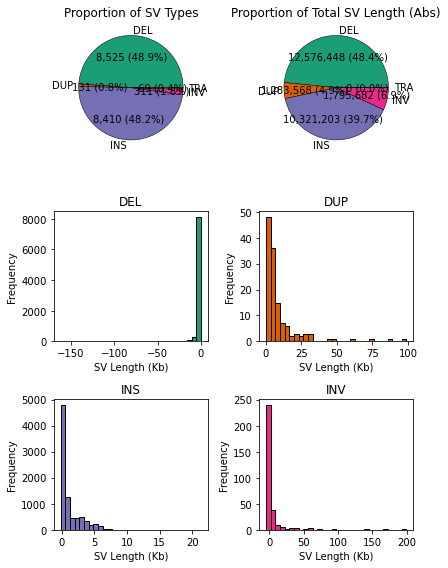

In [63]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assuming you're already in the correct directory
df = pd.read_csv("merged_jedi.csv", sep=",", header=0)

# Define SV types for histograms and pie charts
histogram_svtypes = ["DEL", "DUP", "INS", "INV"]  # Exclude TRA from histograms
piechart_svtypes = ["DEL", "DUP", "INS", "INV", "TRA"]  # Include TRA for pie charts

# Calculate the number of occurrences of each SVTYPE
svtype_counts = df['svtype'].value_counts()

# Calculate the sum of the absolute SVLEN for each SVTYPE
svlen_sums = df.groupby('svtype')['svlen'].apply(lambda x: x.abs().sum())

# Use the "Dark2" colormap and create a color mapping for SV types
cmap = plt.get_cmap("Dark2")
color_mapping = {svtype: cmap(i) for i, svtype in enumerate(piechart_svtypes)}

# Create a figure with 6 subplots (3 rows, 2 columns)
fig, axs = plt.subplots(3, 2, figsize=(6, 8))
axs = axs.flatten()

# Add pie chart for the number of each SVTYPE (including TRA)
axs[0].pie(
    svtype_counts[piechart_svtypes], 
    labels=piechart_svtypes, 
    autopct=lambda pct: f"{int(round(pct/100. * svtype_counts.sum())):,} ({pct:.1f}%)", 
    colors=[color_mapping[svtype] for svtype in piechart_svtypes], 
    wedgeprops={"edgecolor": "black", "linewidth": 0.5}, 
)
axs[0].set_title('Proportion of SV Types')

# Add pie chart for the sum of absolute SVLEN for each SVTYPE (including TRA)
axs[1].pie(
    svlen_sums[piechart_svtypes], 
    labels=piechart_svtypes, 
    autopct=lambda pct: f"{int(round(pct/100. * svlen_sums.sum())):,} ({pct:.1f}%)", 
    colors=[color_mapping[svtype] for svtype in piechart_svtypes], 
    wedgeprops={"edgecolor": "black", "linewidth": 0.5}, 
)
axs[1].set_title('Proportion of Total SV Length (Abs)')

# Loop over the SV types and create a histogram for each (excluding TRA)
for i, svtype in enumerate(histogram_svtypes):
    # Filter the data for the current SV type
    data = df[df["svtype"] == svtype]["svlen"] / 1000
    
    # Plot the histogram with the corresponding color
    axs[i + 2].hist(data, bins=30, color=color_mapping[svtype], edgecolor='black')
    axs[i + 2].set_title(f'{svtype.upper()}')
    axs[i + 2].set_xlabel('SV Length (Kb)')
    axs[i + 2].set_ylabel('Frequency')

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the figure
plt.savefig("../figures_and_tables/fig1_sv_histograms_and_piecharts.png", format="png", dpi=600, facecolor="white")
plt.savefig("../figures_and_tables/fig1_sv_histograms_and_piecharts.svg", facecolor="white")

# Show the plot
plt.show()


## [Figure 2] SV AF histograms

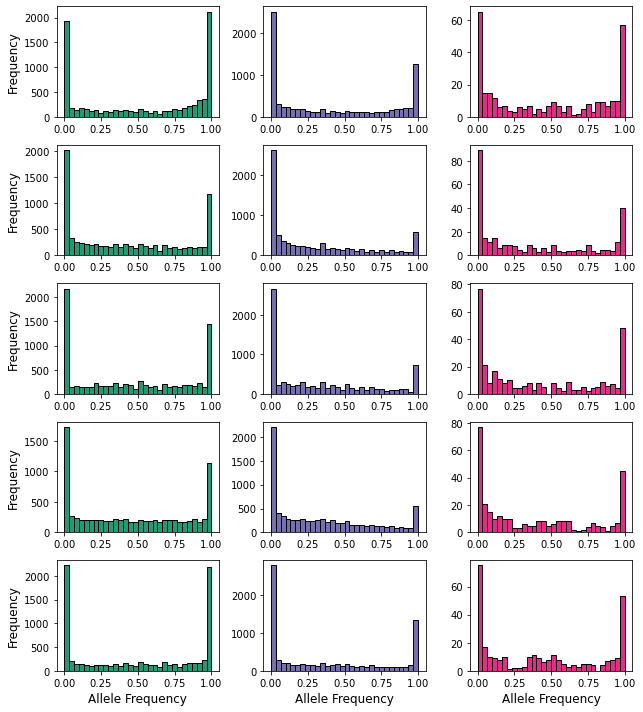

In [64]:
import os
import pandas as pd
import matplotlib.pyplot as plt

os.chdir("{}/results/process_sv_tables".format(proj_dir))

df = pd.read_csv("merged_jedi.csv", sep=",", header=0)

# Define the SV types and allele frequency columns
svtypes = ["DEL", "DUP", "INS", "INV", "TRA"]
af_columns = ['smbre.af', 'smeg.af', 'smle-pzq-er.af', 'smle-pzq-es.af', 'smor.af']

# Use the "Dark2" colormap and create a color mapping for SV types
cmap = plt.get_cmap("Dark2")
color_mapping = {svtype: cmap(i) for i, svtype in enumerate(svtypes)}

# Create a figure with len(af_columns) rows and len(svtypes) columns
fig, axs = plt.subplots(len(af_columns), len(["DEL", "INS", "INV"]), figsize=(9, 10))

# Loop over the rows (af_columns) and columns (svtypes)
for row_idx, af_col in enumerate(af_columns):
    for col_idx, svtype in enumerate(["DEL", "INS", "INV"]):
        # Filter the data for the current svtype
        data = df[df["svtype"] == svtype][af_col].dropna()  # Drop NA values for clean histograms
        
        # Plot the histogram with the corresponding color
        axs[row_idx, col_idx].hist(data, bins=30, color=color_mapping[svtype], edgecolor='black')
        #axs[row_idx, col_idx].set_title(f'{svtype} - {af_col}', fontsize=10)
        
        # Set labels only on the leftmost and bottom plots
        if col_idx == 0:
            axs[row_idx, col_idx].set_ylabel('Frequency', fontsize=12)
        if row_idx == len(af_columns) - 1:
            axs[row_idx, col_idx].set_xlabel('Allele Frequency', fontsize=12)

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the figure
plt.savefig("../figures_and_tables/fig2_svtype_af_histograms.png", format="png", dpi=600, facecolor="white")
plt.savefig("../figures_and_tables/fig2_svtype_af_histograms.svg", facecolor="white")

# Show the plot
plt.show()


# PCA

We used the allele frequencies of each SV to view/estimate relationships between the populations. 

In [65]:
Path(f"{proj_dir}/results/pca_af").mkdir(parents=True, exist_ok=True)
os.chdir(f"{proj_dir}/results/pca_af")

## [Figure 3] PCA relationships

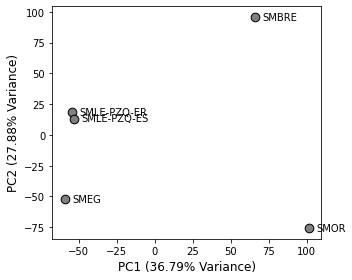

In [67]:
import os
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

os.chdir(f"{proj_dir}/results/pca_af")

df = pd.read_csv(f"{proj_dir}/results/process_sv_tables/merged_jedi.csv", sep=",", header=0)


# Assuming df is your DataFrame and contains the columns for PCA
columns_for_pca = ['smbre.af', 'smeg.af', 'smle-pzq-er.af', 'smle-pzq-es.af', 'smor.af']

# Extract the relevant columns (samples) for PCA
data_for_pca = df.loc[~df["chrom"].isin(["SM_V10_Z", "SM_V10_WSR", "SM_V10_MITO"]), columns_for_pca]

# Handle missing data by dropping rows with NaN values
data_for_pca = data_for_pca.dropna()

# Transpose the data so that rows represent samples and columns represent features
data_for_pca_transposed = data_for_pca.T

# Standardize the transposed data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_for_pca_transposed)

# Perform PCA
pca = PCA(n_components=2)  # We'll compute the first two principal components
pca_result = pca.fit_transform(scaled_data)

# Create a DataFrame with the PCA results
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])

# Get the PC loadings
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'], index=data_for_pca.index)
# Save the loadings to a CSV file
loadings.to_csv("pc_loadings.csv", index=True)

# Add sample names to the DataFrame
pca_df['Sample'] = columns_for_pca

# Plot the PCA results
plt.figure(figsize=(5, 4))
plt.scatter(pca_df['PC1'], pca_df['PC2'], c='grey', edgecolor='k', s=75)
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}% Variance)', fontsize=12)
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}% Variance)', fontsize=12)
# plt.title('PCA of SV Allele Frequencies')
for i, sample in enumerate(pca_df['Sample']):
    plt.text(pca_df['PC1'][i] + 5, pca_df['PC2'][i] + -2.5, sample.replace(".af", "").upper(), fontsize=10)
# plt.grid()
plt.tight_layout()

# save foivure
plt.savefig("../figures_and_tables/fig3_pca_af.png", format="png", dpi=600, facecolor="white")
plt.savefig("../figures_and_tables/fig3_pca_af.svg", facecolor="white")


plt.show()


In [68]:
(pca.explained_variance_ratio_[0] + pca.explained_variance_ratio_[1])*100

64.66674036150917

In [69]:
loadings

,PC1,PC2
7,-1.265377e-02,-5.397780e-04
8,9.659105e-18,1.360293e-17
9,-2.314938e-16,-4.725116e-16
10,1.125877e-02,-8.267996e-03
11,9.060948e-03,-1.014959e-02
...,...,...
14524,4.490296e-03,1.055595e-02
14531,5.816305e-03,1.214283e-02
14533,1.551770e-03,6.461511e-03
14534,9.097642e-03,-1.715343e-03


# Identifying Population-specific SVs

Many of the variants we have identified may only be circulating in one populations.  We do this with two methods.  

1) First we create find SVs criculating at >5% frequncy in each population and then create a venn diagram from those
2) We look for population specific variants at in a single population that are at high frequency >95%.
   
Combined, these analyses identify SVs that are at 95% in one population (at-or-near fixation) and less than 5% in the remaining 4 populations. The skewed differences in allele frequency may be an indicator strong directional selection (but not conclusive).

In [70]:
Path(f"{proj_dir}/results/pop_specific_svs").mkdir(parents=True, exist_ok=True)
os.chdir(f"{proj_dir}/results/pop_specific_svs")

In [71]:
df = pd.read_csv(f"{proj_dir}/results/process_sv_tables/merged_jedi.csv", sep=",", header=0)

In [72]:
#one thing that is useful is to focus only on autosomal variants since any sex-biases in the population pools could incluence SV variation on sex chroms
auto_df = df.loc[~df["chrom"].isin(["SM_V10_Z", "SM_V10_MITO", "SM_V10_WSR"])].reset_index(drop=True)
print(f"There are {len(auto_df)} autosomal SVs")

There are 14536 autosomal SVs


In [73]:
#use a low frequenc
low_freq_cut_off = 0.05
er_svs = set(auto_df.loc[auto_df["smle-pzq-er.af"] > low_freq_cut_off, "sv_id"])
es_svs = set(auto_df.loc[auto_df["smle-pzq-es.af"] > low_freq_cut_off, "sv_id"])
eg_svs = set(auto_df.loc[auto_df["smeg.af"] > low_freq_cut_off, "sv_id"])
or_svs = set(auto_df.loc[auto_df["smor.af"] > low_freq_cut_off, "sv_id"])
bre_svs = set(auto_df.loc[auto_df["smbre.af"] > low_freq_cut_off, "sv_id"])

In [74]:
# Unique to for each pop after low freq filtering
unique_er_svs = er_svs - (es_svs | eg_svs | or_svs | bre_svs)
unique_es_svs = es_svs - (er_svs | eg_svs | or_svs | bre_svs)
unique_eg_svs = eg_svs - (er_svs | es_svs | or_svs | bre_svs)
unique_or_svs = or_svs - (er_svs | es_svs | eg_svs | bre_svs)
unique_bre_svs = bre_svs - (er_svs | es_svs | eg_svs | or_svs)

In [75]:
df.loc[df["sv_id"].isin(unique_er_svs), "svtype"].value_counts()

INS    45
DEL    13
INV     3
Name: svtype, dtype: int64

## [Figure 4] Venn diagram of SV distribution among populations

In [76]:
from itertools import combinations

# Assuming er_svs, es_svs, or_svs, bre_svs, eg_svs are your sets
populations = [er_svs, es_svs, or_svs, bre_svs, eg_svs]

# Total number of unique SVs across all populations
total_svs = len(set.union(*populations))

# Shared by all 5 populations
shared_by_all = set.intersection(*populations)
count_shared_by_all = len(shared_by_all)
percent_shared_by_all = (count_shared_by_all / total_svs) * 100
print(f"Shared by all 5 populations: {count_shared_by_all} SVs ({percent_shared_by_all:.2f}%)")

# Shared by exactly 4 of 5 populations
shared_by_4 = 0
for combo in combinations(populations, 4):
    shared_by_4 += len(set.intersection(*combo) - shared_by_all)
percent_shared_by_4 = (shared_by_4 / total_svs) * 100
print(f"Shared by exactly 4 of 5 populations: {shared_by_4} SVs ({percent_shared_by_4:.2f}%)")

# Shared by exactly 3 of 5 populations
shared_by_3 = 0
for combo in combinations(populations, 3):
    shared_by_3 += len(set.intersection(*combo) - shared_by_all - set.union(*[set.intersection(*c) for c in combinations(populations, 4)]))
percent_shared_by_3 = (shared_by_3 / total_svs) * 100
print(f"Shared by exactly 3 of 5 populations: {shared_by_3} SVs ({percent_shared_by_3:.2f}%)")

# Shared by exactly 2 of 5 populations
shared_by_2 = 0
for combo in combinations(populations, 2):
    shared_by_2 += len(set.intersection(*combo) - shared_by_all - set.union(*[set.intersection(*c) for c in combinations(populations, 3)]))
percent_shared_by_2 = (shared_by_2 / total_svs) * 100
print(f"Shared by exactly 2 of 5 populations: {shared_by_2} SVs ({percent_shared_by_2:.2f}%)")

# Unique to each population
unique_to_each = 0
for population in populations:
    unique_to_each += len(population - set.union(*[p for p in populations if p != population]))
percent_unique_to_each = (unique_to_each / total_svs) * 100
print(f"Unique to each population: {unique_to_each} SVs ({percent_unique_to_each:.2f}%)")


Shared by all 5 populations: 5349 SVs (38.97%)
Shared by exactly 4 of 5 populations: 2747 SVs (20.01%)
Shared by exactly 3 of 5 populations: 2296 SVs (16.73%)
Shared by exactly 2 of 5 populations: 1687 SVs (12.29%)
Unique to each population: 1648 SVs (12.01%)


/master/nplatt/miniconda3/envs/sm_ont_jupyter/lib/python3.6/site-packages/venn/_backwards_compatibility.py:17: UserWarning: `get_labels()` is retained for backwards compatibility; use `generate_petal_labels()` or the higher level `venn()` instead
  "use `generate_petal_labels()` or the higher level `venn()` instead"
/master/nplatt/miniconda3/envs/sm_ont_jupyter/lib/python3.6/site-packages/venn/_backwards_compatibility.py:32: UserWarning: `venn5()` is retained for backwards compatibility; use `venn()` instead
  "use `venn()` instead"


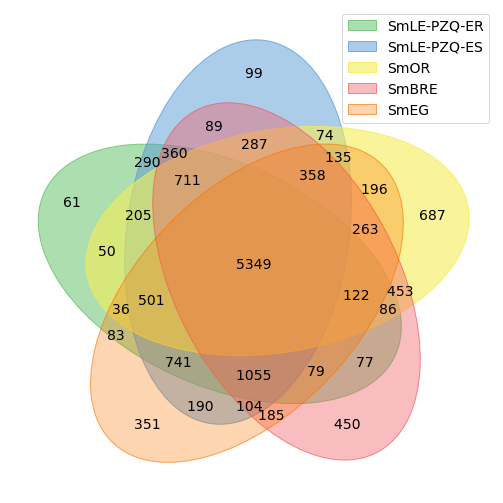

In [77]:
labels = venn.get_labels([er_svs, es_svs, or_svs, bre_svs, eg_svs], fill=["number"])

fig, ax = venn.venn2(
    labels, names=["SmLE-PZQ-ER", "SmLE-PZQ-ES", "SmOR", "SmBRE", "SmEG"]
)

# save foivure
fig.savefig("../figures_and_tables/fig4_venn_5perc.png", format="png", dpi=600, facecolor="white")
fig.savefig("../figures_and_tables/fig4_venn_5perc.svg", facecolor="white")

fig.show()

## High frequency population specific SVs

If you look at the frequency of each of the population specific SVs you see that a disproportionate number of them are at high and low frequencies. We want to find the ones that are at high frequency in a single population and low frequencies in the other 4

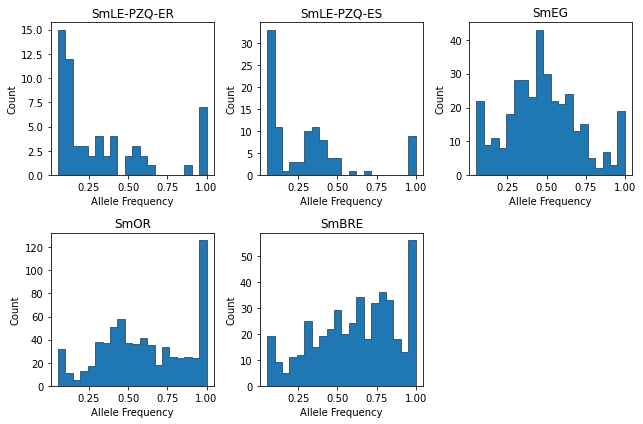

In [78]:
import matplotlib.pyplot as plt

# Create a figure with 5 subplots (2 row, 3 columns)
fig, axs = plt.subplots(2,3, figsize=(9, 6))
axs = axs.flatten()

# Plot each histogram in its respective subplot
axs[0].hist(df.loc[df["sv_id"].isin(unique_er_svs), "smle-pzq-er.af"], 
            histtype="stepfilled", linewidth=0.5, alpha=1, bins=20, label="SmLE-PZQ-ER", density=False, edgecolor='black')
axs[0].set_title("SmLE-PZQ-ER")
axs[0].set_xlabel('Allele Frequency')
axs[0].set_ylabel('Count')

axs[1].hist(df.loc[df["sv_id"].isin(unique_es_svs), "smle-pzq-es.af"], 
            histtype="stepfilled", linewidth=0.5, alpha=1, bins=20, label="SmLE-PZQ-ES", density=False, edgecolor='black')
axs[1].set_title("SmLE-PZQ-ES")
axs[1].set_xlabel('Allele Frequency')
axs[1].set_ylabel('Count')

axs[2].hist(df.loc[df["sv_id"].isin(unique_eg_svs), "smeg.af"], 
            histtype="stepfilled", linewidth=0.5, alpha=1, bins=20, label="SmEG", density=False, edgecolor='black')
axs[2].set_title("SmEG")
axs[2].set_xlabel('Allele Frequency')
axs[2].set_ylabel('Count')

axs[3].hist(df.loc[df["sv_id"].isin(unique_or_svs), "smor.af"], 
            histtype="stepfilled", linewidth=0.5, alpha=1, bins=20, label="SmOR", density=False, edgecolor='black')
axs[3].set_title("SmOR")
axs[3].set_xlabel('Allele Frequency')
axs[3].set_ylabel('Count')

axs[4].hist(df.loc[df["sv_id"].isin(unique_bre_svs), "smbre.af"], 
            histtype="stepfilled", linewidth=0.5, alpha=1, bins=20, label="SmBRE", density=False, edgecolor='black')
axs[4].set_title("SmBRE")
axs[4].set_xlabel('Allele Frequency')
axs[4].set_ylabel('Count')

# Remove the empty subplot (axs[5])
fig.delaxes(axs[5])

# Adjust layout to prevent overlap
plt.tight_layout()

fig.savefig("../figures_and_tables/pop_specific_allele_freq.png", format="png", dpi=600, facecolor="white")
fig.savefig("../figures_and_tables/pop_specific_allele_freq.svg", facecolor="white")

# Show the plot
plt.show()


In [ ]:
specific_pops = [unique_sv_dict[x] for x in pop_specific_df["sv_id"]]
specific_pops

With this information, we can extract all of the pop-specific SVs wtih 95% or greater AF

In [83]:
#now create a dict that has each SV and the pop it belongs to
unique_sv_dict = {}
unique_sv_dict.update({sv: "smle-pzq-er" for sv in unique_er_svs})
unique_sv_dict.update({sv: "smle-pzq-es" for sv in unique_es_svs})
unique_sv_dict.update({sv: "smeg" for sv in unique_eg_svs})
unique_sv_dict.update({sv: "smor" for sv in unique_or_svs})
unique_sv_dict.update({sv: "smbre" for sv in unique_bre_svs})

#get them in a list
pop_specific_svs = unique_sv_dict.keys()

#now find them in the SV dataframe if something is pop specific and >0.95 in one of the populations.
cutoff=0.95
af_cols = ['smbre.af', 'smeg.af', 'smle-pzq-er.af', 'smle-pzq-es.af', 'smor.af']

pop_specific_df = df.loc[
    (df[af_cols] >= cutoff).any(axis=1) &
    df["sv_id"].isin(pop_specific_svs)
].dropna()

#now create a dict that only has the high freq pop specific SVs and hav they values be the pop
specific_pops = [unique_sv_dict[x] for x in pop_specific_df["sv_id"]]
pop_specific_df["specific_pop"]=specific_pops
pop_specific_dict = pop_specific_df.set_index("sv_id")["specific_pop"].to_dict()

#update the dataframes so that there is a pop_specific column in each
for dataframe in [df, all_gtf_df, merged_df]:
    dataframe["specific_pop"] = dataframe["sv_id"].apply(lambda x: pop_specific_dict.get(x, "none"))

#and save back to the original table location
df.to_csv(f"{proj_dir}/results/process_sv_tables/merged_jedi.csv", sep=",", header=True, index=False)
all_gtf_df.to_csv(f"{proj_dir}/results/process_sv_tables/all_svs_vs_genes.csv", sep=",", header=True, index=False)
merged_df.to_csv(f"{proj_dir}/results/process_sv_tables/merged_jedi_gtf.csv", sep=",", header=True, index=False)

## [Supplemental Table 1] Population specific variants

Create a table that lists the different SVs that are population specific.  Include the allele frequencies, the pop they variant belongs to, and the genes that are impacted (if any).

In [84]:
# Select relevant columns from pop_specific_df
table_df = pop_specific_df[["sv_id", "chrom", "pos", "end", "svtype", "smle-pzq-er.af", "smle-pzq-es.af", "smor.af", "smbre.af", "smeg.af", "specific_pop"]].copy()

# Group by 'sv_id' and aggregate the 'gene' column by joining the values into a string, ignoring NaNs
grouped_genes = (
    merged_df.loc[merged_df["specific_pop"] != "none"]
    .groupby("sv_id")["gene"]
    .agg(lambda x: ", ".join(sorted(set(str(g) for g in x if pd.notna(g)))))
    .reset_index()
)

# Merge the grouped_genes back into table_df on 'sv_id'
table_df = table_df.merge(grouped_genes, on="sv_id", how="left")

# Save the final table to CSV
table_df.to_csv("../figures_and_tables/stable-1_pop_specific_svs.csv", sep=",", header=True, index=False)

table_df

,sv_id,chrom,pos,end,svtype,smle-pzq-er.af,smle-pzq-es.af,smor.af,smbre.af,smeg.af,specific_pop,gene
0,INS-SM_V10_1:18826864,SM_V10_1,18826864,18826864,INS,0.000000,0.000000,0.954545,0.037037,0.0,smor,Smp_069380
1,INS-SM_V10_1:19701652,SM_V10_1,19701652,19701652,INS,0.000000,0.000000,1.000000,0.000000,0.0,smor,Smp_307220
2,INS-SM_V10_1:19706163,SM_V10_1,19706163,19706163,INS,0.000000,0.022727,1.000000,0.000000,0.0,smor,Smp_307220
3,DEL-SM_V10_1:19722114,SM_V10_1,19722114,19722496,DEL,0.000000,0.000000,0.962963,0.000000,0.0,smor,
4,INS-SM_V10_1:19790938,SM_V10_1,19790938,19790938,INS,0.045455,0.000000,0.952381,0.000000,0.0,smor,Smp_307240
...,...,...,...,...,...,...,...,...,...,...,...,...
163,INS-SM_V10_6:17310756,SM_V10_6,17310756,17310756,INS,0.000000,0.000000,0.000000,0.000000,1.0,smeg,Smp_070250
164,DEL-SM_V10_7:1006769,SM_V10_7,1006769,1006853,DEL,0.000000,0.024390,0.000000,1.000000,0.0,smbre,Smp_341770
165,DEL-SM_V10_7:6940305,SM_V10_7,6940305,6940563,DEL,0.000000,0.000000,0.000000,0.000000,1.0,smeg,Smp_080870
166,INS-SM_V10_7:10557604,SM_V10_7,10557604,10557604,INS,0.000000,0.000000,0.962963,0.000000,0.0,smor,Smp_144660


## General questions about pop specific variants

In [85]:
#how many pop specific variants did we find per population
pop_specific_df["specific_pop"].value_counts()

smor     114
smbre     46
smeg       8
Name: specific_pop, dtype: int64

In [87]:
#how many pop specific variants impact genes
table_df.loc[table_df["gene"] != ""]

,sv_id,chrom,pos,end,svtype,smle-pzq-er.af,smle-pzq-es.af,smor.af,smbre.af,smeg.af,specific_pop,gene
0,INS-SM_V10_1:18826864,SM_V10_1,18826864,18826864,INS,0.000000,0.000000,0.954545,0.037037,0.0,smor,Smp_069380
1,INS-SM_V10_1:19701652,SM_V10_1,19701652,19701652,INS,0.000000,0.000000,1.000000,0.000000,0.0,smor,Smp_307220
2,INS-SM_V10_1:19706163,SM_V10_1,19706163,19706163,INS,0.000000,0.022727,1.000000,0.000000,0.0,smor,Smp_307220
4,INS-SM_V10_1:19790938,SM_V10_1,19790938,19790938,INS,0.045455,0.000000,0.952381,0.000000,0.0,smor,Smp_307240
5,INS-SM_V10_1:19941568,SM_V10_1,19941568,19941568,INS,0.000000,0.020833,1.000000,0.000000,0.0,smor,Smp_076960
...,...,...,...,...,...,...,...,...,...,...,...,...
158,INS-SM_V10_6:13488241,SM_V10_6,13488241,13488241,INS,0.000000,0.000000,0.000000,1.000000,0.0,smbre,Smp_342090
163,INS-SM_V10_6:17310756,SM_V10_6,17310756,17310756,INS,0.000000,0.000000,0.000000,0.000000,1.0,smeg,Smp_070250
164,DEL-SM_V10_7:1006769,SM_V10_7,1006769,1006853,DEL,0.000000,0.024390,0.000000,1.000000,0.0,smbre,Smp_341770
165,DEL-SM_V10_7:6940305,SM_V10_7,6940305,6940563,DEL,0.000000,0.000000,0.000000,0.000000,1.0,smeg,Smp_080870


In [88]:
#how many genes are impacted by pop specific variants
len(set((merged_df.loc[ ((merged_df["gtf_feature"] == "gene") & (merged_df["specific_pop"] != "none")), "gene"])))

56

In [89]:
#What genes are affected in the CDS by pop specific variants:
target_gene_regions = ['exon', 'CDS', 'start_codon', 'stop_codon',
       'five_prime_utr', 'three_prime_utr']
set(merged_df.loc[ ((merged_df["gtf_feature"].isin(target_gene_regions)) & (merged_df["specific_pop"] != "none")), "gene"])

{'Smp_076960',
 'Smp_158710',
 'Smp_315070',
 'Smp_327700',
 'Smp_327710',
 'Smp_342090'}

In [90]:
#how many genes have SVs in general
len(set(merged_df.loc[ merged_df["gtf_feature"] == "gene", "gene"]))

6103

## Select pop specific PCR primers for validation

In [91]:
pop_pcr_df = df.loc[ ( (df["specific_pop"] != "none") &
                   (abs(df["svlen"])<=400) &
                   (abs(df["svlen"])>=150) )]
pop_pcr_df.to_csv(f"{proj_dir}/results/pcr/pop_specific_pre-pcr.csv", sep=",", header=True, index=False)
pop_pcr_df

,chrom,pos,end,id,ciend,svlen,svtype,smeg.gt,smeg.dp,smeg.ad,...,smor.dp,smor.ad,smor.pl,smbre.af,smle-pzq-er.af,smle-pzq-es.af,smeg.af,smor.af,sv_id,specific_pop
871,SM_V10_1,19722114,19722496,cuteSV.DEL.911,"0,0",-382,DEL,0/0,23.0,"23,0",...,27.0,"1,26","1103,66,28",0.000000,0.000000,0.000000,0.000000,0.962963,DEL-SM_V10_1:19722114,smor
907,SM_V10_1,20567930,20568099,cuteSV.DEL.929,"0,0",-169,DEL,0/0,17.5,"17.5,0",...,17.0,"0,17","731,51,0",0.000000,0.000000,0.000000,0.000000,1.000000,DEL-SM_V10_1:20567930,smor
1842,SM_V10_1,58896631,58896977,cuteSV.DEL.2047,"0,0",-346,DEL,0/0,14.0,"14,0",...,11.5,"0.5,11","473,34,21",0.000000,0.000000,0.000000,0.000000,0.956522,DEL-SM_V10_1:58896631,smor
2850,SM_V10_2,270134,270490,cuteSV.DEL.3047,"0,0",-356,DEL,0/0,17.5,"17.5,0",...,10.0,"0,10","430,30,0",0.000000,0.000000,0.020619,0.000000,1.000000,DEL-SM_V10_2:270134,smor
2851,SM_V10_2,273645,273955,cuteSV.DEL.3049,"0,0",-310,DEL,0/0,21.0,"21,0",...,18.0,"0,18","774,54,0",0.000000,0.000000,0.000000,0.000000,1.000000,DEL-SM_V10_2:273645,smor
2876,SM_V10_2,446227,446389,cuteSV.DEL.3023,"0,0",-162,DEL,0/0,21.0,"20,1",...,24.0,"24,0","0,72,1032",1.000000,0.000000,0.000000,0.047619,0.000000,DEL-SM_V10_2:446227,smbre
2896,SM_V10_2,537014,537245,cuteSV.DEL.3102,"0,0",-231,DEL,0/0,23.5,"23.5,0",...,24.0,"0,24","1032,72,0",0.041667,0.000000,0.000000,0.000000,1.000000,DEL-SM_V10_2:537014,smor
2910,SM_V10_2,601515,601515,cuteSV.INS.3319,"0,0",286,INS,0/0,31.0,"30,1",...,25.0,"0,25","1075,75,0",0.000000,0.000000,0.000000,0.032258,1.000000,INS-SM_V10_2:601515,smor
3010,SM_V10_2,1128620,1128942,cuteSV.DEL.3162,"0,0",-322,DEL,0/0,25.0,"25,0",...,29.0,"0,29","1247,87,0",0.000000,0.000000,0.000000,0.000000,1.000000,DEL-SM_V10_2:1128620,smor
3034,SM_V10_2,1202783,1202783,cuteSV.INS.3362,"0,0",155,INS,0/0,18.0,"18,0",...,15.5,"0,15.5","666,46,0",0.000000,0.000000,0.000000,0.000000,1.000000,INS-SM_V10_2:1202783,smor


## Select loci impacting genes for PCR

In [1223]:
coding_pcr_df = merged_df.loc[ ((merged_df["gtf_feature"].isin(target_gene_regions)) & (merged_df["specific_pop"] != "none"))].copy()
coding_pcr_df = coding_pcr_df.drop_duplicates(subset='sv_id', keep='first')

coding_pcr_df.to_csv(f"{proj_dir}/results/pcr/coding_pre-pcr.csv", sep=",", header=True, index=False)

coding_pcr_df

,chrom,pos,end,id,ciend,svlen,svtype,smeg.gt,smeg.dp,smeg.ad,...,gtf_feature,gtf_start,gtf_end,gtf_score,gtf_strand,gtf_frame,gtf_attribute,bp_overlap,gene,specific_pop
46913,SM_V10_1,19941568,19941568,cuteSV.INS.883,"0,0",419,INS,0/0,27.0,"27,0",...,exon,19927882.0,19946313.0,.,-,.,"gene_id ""Smp_076960""; gene_version ""1""; transc...",0.0,Smp_076960,smor
125913,SM_V10_2,3848692,3878697,cuteSV.INV.113,"0,0",30005,INV,0/0,7.0,"7,0",...,exon,3862951.0,3863052.0,.,-,.,"gene_id ""Smp_327700""; gene_version ""1""; transc...",102.0,Smp_327700,smor
275835,SM_V10_6,603144,603144,cuteSV.INS.10794,"0,0",2293,INS,0/0,24.0,"24,0",...,exon,602591.0,605743.0,.,+,.,"gene_id ""Smp_315070""; gene_version ""1""; transc...",0.0,Smp_315070,smor
275839,SM_V10_6,603467,603467,cuteSV.INS.10795,"0,0",577,INS,0/0,25.0,"25,0",...,exon,602591.0,605743.0,.,+,.,"gene_id ""Smp_315070""; gene_version ""1""; transc...",0.0,Smp_315070,smor
276436,SM_V10_6,6022561,6022739,cuteSV.DEL.10928,"0,0",-178,DEL,0/0,27.0,"27,0",...,exon,6022699.0,6023100.0,.,+,.,"gene_id ""Smp_158710""; gene_version ""1""; transc...",41.0,Smp_158710,smor
276930,SM_V10_6,13488241,13488241,cuteSV.INS.12142,"0,0",364,INS,0/0,21.0,"21,0",...,exon,13485939.0,13544748.0,.,+,.,"gene_id ""Smp_342090""; gene_version ""1""; transc...",0.0,Smp_342090,smbre


# Identify SVs in QTLs

In [1166]:
Path(f"{proj_dir}/results/qtls").mkdir(parents=True, exist_ok=True)
os.chdir(f"{proj_dir}/results/qtls")

## Liftover coordinates from previous SMV7 to SMV10

In [ ]:
%%bash

conda activate liftover

echo -e """SM_V7_1\t42010946\t53482618
SM_V7_2\t43954213\t47725512
SM_V7_3\t3914558\t5238304
SM_V7_4\t27609036\t30741077
SM_V7_5\t19823314\t23768112""">v7_coords.bed

minimap2 -cx asm5 -t 96 SM_V10.fa Smansoni_v7.fa >v7_to_v10.paf
paftools.js liftover v7_to_v10.paf v7_coords.bed  >v10_coords.bed

Once these bedfiles were generated, I added qtls that are already available for SMV10 to qtls.bed

In [791]:
qtl_df = pd.read_csv("qtls.bed", header=None, sep="\t", names=["chrom", "start", "stop", "qtl"])
qtl_df

,chrom,start,stop,qtl
0,SM_V10_3,271314,5994738,pzq
1,SM_V10_1,41070262,52541936,cp1
2,SM_V10_3,5895758,7219504,cp3
3,SM_V10_2,41597599,45311388,cp2
4,SM_V10_4,26999137,30131178,cp4
5,SM_V10_5,18834925,22640851,cp5


### How many SVs exist in each QTL?

In [795]:
for index, row in qtl_df.iterrows():
    chrom = row["chrom"]
    start = row["start"]
    stop = row["stop"]
    qtl = row["qtl"]

    tmp_df = a = df.loc[ ((df["chrom"] == chrom) &
         (df["pos"] >= start) &
         (df["end"] <=stop))].dropna()

    print(len(tmp_df))

593
298
74
246
64
237


### How many pop specific SVs exist in each QTL?

In [1169]:
for index, row in qtl_df.iterrows():
    chrom = row["chrom"]
    start = row["start"]
    stop = row["stop"]
    qtl = row["qtl"]

    tmp_df = pop_specific_df.loc[ ((df["chrom"] == chrom) &
         (df["pos"] >= start) &
         (df["end"] <=stop))].dropna()

    print(len(tmp_df))

2
0
1
0
3
1


So the previous results tell us that there are some pop specific qtls in some of the target loci, but it doesn't tell us if the pop specific qtls exist in one of the lineages that the association was done with.  We need to look at each one specifically

### PZQ QTL

In [1172]:
qtl_df.loc[qtl_df["qtl"] == "pzq"]

,chrom,start,stop,qtl
0,SM_V10_3,271314,5994738,pzq


In [1182]:
pzq_chrom = qtl_df.loc[qtl_df["qtl"] == "pzq", "chrom"].values[0]
pzq_start = qtl_df.loc[qtl_df["qtl"] == "pzq", "start"].values[0]
pzq_stop  = qtl_df.loc[qtl_df["qtl"] == "pzq", "stop"].values[0]

pzq_df = merged_df.loc[ ((merged_df["chrom"] == pzq_chrom) &
     (merged_df["start"] >= pzq_start) &
     (merged_df["end"] <=pzq_stop) &
     (abs(merged_df["smle-pzq-er.af"] - merged_df["smle-pzq-es.af"]) > 0.95))].dropna().drop_duplicates(subset='sv_id', keep='first')

pzq_df

,chrom,pos,end,id,ciend,svlen,svtype,smeg.gt,smeg.dp,smeg.ad,...,gtf_feature,gtf_start,gtf_end,gtf_score,gtf_strand,gtf_frame,gtf_attribute,bp_overlap,gene,specific_pop
176702,SM_V10_3,2969428,2973340,cuteSV.DEL.7865,"0,1",-3912,DEL,1/1,27.0,"0,27",...,gene,2951563.0,3027139.0,.,+,.,"gene_id ""Smp_345310""; gene_version ""1""; gene_s...",3912.0,Smp_345310,none
176744,SM_V10_3,3194040,3194564,cuteSV.DEL.5562,"0,0",-524,DEL,0/0,27.0,"27,0",...,gene,3107700.0,3202414.0,.,+,.,"gene_id ""Smp_307630""; gene_version ""1""; gene_s...",524.0,Smp_307630,none


### CP QTLs

In [1213]:
cp_df = pd.DataFrame()
i_s = []

for index, row in qtl_df.loc[qtl_df["qtl"] != "pzq"].iterrows():
    chrom = row["chrom"]
    start = row["start"]
    stop = row["stop"]
    qtl = row["qtl"]

    tmp_df = merged_df.loc[ ((merged_df["chrom"] == chrom) &
         (merged_df["start"] >= start) &
         (merged_df["end"] <=stop) &
         (    (abs(merged_df["smle-pzq-er.af"] - merged_df["smbre.af"]) >= 0.95) | 
              (abs(merged_df["smle-pzq-es.af"] - merged_df["smbre.af"]) >= 0.95)  )
                            )].dropna()

    cp_df = pd.concat([qtl_pcr_df, tmp_df])
    
    print(f"The qtl, {qtl}, has {len(tmp_df['sv_id'].unique())} variants of interest")

cp_df = cp_df.sort_values(by='sv_id', ascending=False).drop_duplicates(subset='sv_id', keep='first')
cp_df

The qtl, cp1, has 2 variants of interest
The qtl, cp3, has 0 variants of interest
The qtl, cp2, has 3 variants of interest
The qtl, cp4, has 1 variants of interest
The qtl, cp5, has 0 variants of interest


,chrom,pos,end,id,ciend,svlen,svtype,smeg.gt,smeg.dp,smeg.ad,...,gtf_feature,gtf_start,gtf_end,gtf_score,gtf_strand,gtf_frame,gtf_attribute,bp_overlap,gene,specific_pop
169283,SM_V10_2,43025088,43025088,cuteSV.INS.3045,"0,0",156,INS,0/1,16.0,"9,7",...,transcript,43018997.0,43037066.0,.,-,.,"gene_id ""Smp_333970""; gene_version ""1""; transc...",0.0,Smp_333970,none
169260,SM_V10_2,42931108,42931108,cuteSV.INS.3953,"-1,0",111,INS,0/1,11.0,"3,8",...,gene,42919065.0,42978769.0,.,+,.,"gene_id ""Smp_246050""; gene_version ""1""; gene_s...",0.0,Smp_246050,none
68457,SM_V10_1,51653082,51653082,cuteSV.INS.1983,"-25,0",328,INS,0/0,21.0,"21,0",...,transcript,51619721.0,51675191.0,.,+,.,"gene_id ""Smp_141710""; gene_version ""1""; transc...",0.0,Smp_141710,none
254118,SM_V10_4,28390821,28391441,cuteSV.DEL.12953,"0,3",-619,DEL,0/1,26.0,"16,10",...,gene,28375866.0,28418641.0,.,-,.,"gene_id ""Smp_058980""; gene_version ""1""; gene_s...",620.0,Smp_058980,none
169253,SM_V10_2,42927789,42928211,cuteSV.DEL.3715,"-1,0",-423,DEL,0/1,12.0,"2,10",...,transcript,42919065.0,42978769.0,.,+,.,"gene_id ""Smp_246050""; gene_version ""1""; transc...",422.0,Smp_246050,none
68463,SM_V10_1,51798105,51798574,cuteSV.DEL.2774,"-6,0",-463,DEL,0/0,15.0,"15,0",...,transcript,51784355.0,51820832.0,.,+,.,"gene_id ""Smp_343460""; gene_version ""1""; transc...",469.0,Smp_343460,none


### Are any of the CP or PZQ QTLS in coding regions

In [1218]:
target_gene_regions = ['exon', 'CDS', 'start_codon', 'stop_codon',
       'five_prime_utr', 'three_prime_utr']

qtl_svs = np.union1d(cp_df["sv_id"].unique(), pzq_df["sv_id"].unique()).tolist()

merged_df.loc[ ( (merged_df["sv_id"].isin(qtl_svs)) & (merged_df["gtf_feature"].isin(target_gene_regions) ) ) ]

,chrom,pos,end,id,ciend,svlen,svtype,smeg.gt,smeg.dp,smeg.ad,...,gtf_feature,gtf_start,gtf_end,gtf_score,gtf_strand,gtf_frame,gtf_attribute,bp_overlap,gene,specific_pop


### Select SVs within QTLs for PCR

In [1224]:
qtl_pcr_df = merged_df.loc[merged_df["sv_id"].isin(qtl_svs)].drop_duplicates(subset='sv_id', keep='first')
qtl_pcr_df.to_csv(f"{proj_dir}/results/pcr/qtl_pre-pcr.csv", sep=",", header=True, index=False)

qtl_pcr_df

,chrom,pos,end,id,ciend,svlen,svtype,smeg.gt,smeg.dp,smeg.ad,...,gtf_feature,gtf_start,gtf_end,gtf_score,gtf_strand,gtf_frame,gtf_attribute,bp_overlap,gene,specific_pop
68456,SM_V10_1,51653082,51653082,cuteSV.INS.1983,"-25,0",328,INS,0/0,21.0,"21,0",...,gene,51619721.0,51675191.0,.,+,.,"gene_id ""Smp_141710""; gene_version ""1""; gene_s...",0.0,Smp_141710,none
68462,SM_V10_1,51798105,51798574,cuteSV.DEL.2774,"-6,0",-463,DEL,0/0,15.0,"15,0",...,gene,51784355.0,51820832.0,.,+,.,"gene_id ""Smp_343460""; gene_version ""1""; gene_s...",469.0,Smp_343460,none
169248,SM_V10_2,42927789,42928211,cuteSV.DEL.3715,"-1,0",-423,DEL,0/1,12.0,"2,10",...,gene,42919065.0,42978769.0,.,+,.,"gene_id ""Smp_246050""; gene_version ""1""; gene_s...",422.0,Smp_246050,none
169260,SM_V10_2,42931108,42931108,cuteSV.INS.3953,"-1,0",111,INS,0/1,11.0,"3,8",...,gene,42919065.0,42978769.0,.,+,.,"gene_id ""Smp_246050""; gene_version ""1""; gene_s...",0.0,Smp_246050,none
169282,SM_V10_2,43025088,43025088,cuteSV.INS.3045,"0,0",156,INS,0/1,16.0,"9,7",...,gene,43018997.0,43037066.0,.,-,.,"gene_id ""Smp_333970""; gene_version ""1""; gene_s...",0.0,Smp_333970,none
176702,SM_V10_3,2969428,2973340,cuteSV.DEL.7865,"0,1",-3912,DEL,1/1,27.0,"0,27",...,gene,2951563.0,3027139.0,.,+,.,"gene_id ""Smp_345310""; gene_version ""1""; gene_s...",3912.0,Smp_345310,none
176744,SM_V10_3,3194040,3194564,cuteSV.DEL.5562,"0,0",-524,DEL,0/0,27.0,"27,0",...,gene,3107700.0,3202414.0,.,+,.,"gene_id ""Smp_307630""; gene_version ""1""; gene_s...",524.0,Smp_307630,none
254118,SM_V10_4,28390821,28391441,cuteSV.DEL.12953,"0,3",-619,DEL,0/1,26.0,"16,10",...,gene,28375866.0,28418641.0,.,-,.,"gene_id ""Smp_058980""; gene_version ""1""; gene_s...",620.0,Smp_058980,none


# Primer design for PCR Validation 

In [5]:
Path(f"{proj_dir}/results/pcr").mkdir(parents=True, exist_ok=True)
os.chdir(f"{proj_dir}/results/pcr")

In [6]:
df = pd.read_csv(f"{proj_dir}/results/process_sv_tables/merged_jedi.csv", sep=",", header=0)

In [8]:
#get the target svs from coding, pop-specific, and qtl analyses
coding_pcr_df = pd.read_csv("coding_pre-pcr.csv", sep=",", header=0)
pop_pcr_df = pd.read_csv("pop_specific_pre-pcr.csv", sep=",", header=0)
qtl_pcr_df = pd.read_csv("qtl_pre-pcr.csv", sep=",", header=0)

#create a single list of ids and subset them from df
sv_ids = pd.concat([coding_pcr_df["sv_id"], pop_pcr_df["sv_id"], qtl_pcr_df["sv_id"]]).unique()
pcr_df = df.loc[df["sv_id"].isin(sv_ids)]

#now we are going to add a reason why each sv was chosen
pcr_df["reason"] = ""
pcr_df.loc[pcr_df["sv_id"].isin(pop_pcr_df["sv_id"]), "reason"] = "pop_specific"
pcr_df.loc[pcr_df["sv_id"].isin(coding_pcr_df["sv_id"]), "reason"] = "coding"
pcr_df.loc[pcr_df["sv_id"].isin(qtl_pcr_df["sv_id"]), "reason"] = "qtl"

#print out
pcr_df.head()

/master/nplatt/miniconda3/envs/sm_ont_jupyter/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/master/nplatt/miniconda3/envs/sm_ont_jupyter/lib/python3.6/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


,chrom,pos,end,id,ciend,svlen,svtype,smeg.gt,smeg.dp,smeg.ad,...,smor.ad,smor.pl,smbre.af,smle-pzq-er.af,smle-pzq-es.af,smeg.af,smor.af,sv_id,specific_pop,reason
871,SM_V10_1,19722114,19722496,cuteSV.DEL.911,"0,0",-382,DEL,0/0,23.0,"23,0",...,"1,26","1103,66,28",0.0,0.0,0.000000,0.0,0.962963,DEL-SM_V10_1:19722114,smor,pop_specific
884,SM_V10_1,19941568,19941568,cuteSV.INS.883,"0,0",419,INS,0/0,27.0,"27,0",...,"0,36","1548,108,0",0.0,0.0,0.020833,0.0,1.000000,INS-SM_V10_1:19941568,smor,coding
907,SM_V10_1,20567930,20568099,cuteSV.DEL.929,"0,0",-169,DEL,0/0,17.5,"17.5,0",...,"0,17","731,51,0",0.0,0.0,0.000000,0.0,1.000000,DEL-SM_V10_1:20567930,smor,pop_specific
1698,SM_V10_1,51653082,51653082,cuteSV.INS.1983,"-25,0",328,INS,0/0,21.0,"21,0",...,"28,1","28,72,1189",1.0,0.0,0.438596,0.0,0.034483,INS-SM_V10_1:51653082,none,qtl
1702,SM_V10_1,51798105,51798574,cuteSV.DEL.2774,"-6,0",-463,DEL,0/0,15.0,"15,0",...,"0,30","1290,90,0",1.0,0.0,0.515464,0.0,1.000000,DEL-SM_V10_1:51798105,none,qtl


In [1296]:
#find loci in a reasonable size range
# need to take abs value to keep the deletions (which are negative in size)
abs_svlens=abs(pcr_df["svlen"])

pcr_df = pcr_df.loc[ ( (abs_svlens <900) & (abs_svlens>150) )].copy()
pcr_df.loc[ ( (abs_svlens <900) & (abs_svlens>150) ), "reason"].value_counts()

reason
pop_specific    38
qtl              6
coding           4
Name: count, dtype: int64

## now lets examine these on IGV to pick the ones to validate

In [1297]:
pcr_df[["chrom", "pos"]].to_csv("to_validate.list", sep="\t", header=False, index=False)

In [ ]:
%%bash

conda run -n vcftools vcftools --positions to_validate.list --vcf ../survivor/survivor.vcf --recode --recode-INFO-all --stdout >to_validate.vcf
#so there is a weir thing here where there is an extra empty line at the end of the vcf that causes problems and needs to be deleted

In [ ]:
%%bash 

conda run -n igv --cwd . --live-stream \
    create_report \
        to_validate.vcf \
        --flanking 250  \
        --output to_validate.igv.html \
        --fasta ../../data/genome/SM_V10.fa \
        --tracks to_validate.vcf ../minimap2/smeg.bam ../minimap2/smor.bam ../minimap2/smle-pzq-er.bam ../minimap2/smle-pzq-es.bam ../minimap2/smbre.bam

In [1268]:
pcr_df[["chrom", "pos", "end", "id", "sv_id", "svlen", "specific_pop", "reason", "smle-pzq-er.af", "smle-pzq-es.af", "smor.af", "smbre.af", "smeg.af"]]

,chrom,pos,end,id,sv_id,svlen,specific_pop,reason,smle-pzq-er.af,smle-pzq-es.af,smor.af,smbre.af,smeg.af
871,SM_V10_1,19722114,19722496,cuteSV.DEL.911,DEL-SM_V10_1:19722114,-382,smor,pop_specific,0.000000,0.000000,0.962963,0.000000,0.000000
884,SM_V10_1,19941568,19941568,cuteSV.INS.883,INS-SM_V10_1:19941568,419,smor,coding,0.000000,0.020833,1.000000,0.000000,0.000000
907,SM_V10_1,20567930,20568099,cuteSV.DEL.929,DEL-SM_V10_1:20567930,-169,smor,pop_specific,0.000000,0.000000,1.000000,0.000000,0.000000
1698,SM_V10_1,51653082,51653082,cuteSV.INS.1983,INS-SM_V10_1:51653082,328,none,qtl,0.000000,0.438596,0.034483,1.000000,0.000000
1702,SM_V10_1,51798105,51798574,cuteSV.DEL.2774,DEL-SM_V10_1:51798105,-463,none,qtl,0.000000,0.515464,1.000000,1.000000,0.000000
1842,SM_V10_1,58896631,58896977,cuteSV.DEL.2047,DEL-SM_V10_1:58896631,-346,smor,pop_specific,0.000000,0.000000,0.956522,0.000000,0.000000
2850,SM_V10_2,270134,270490,cuteSV.DEL.3047,DEL-SM_V10_2:270134,-356,smor,pop_specific,0.000000,0.020619,1.000000,0.000000,0.000000
2851,SM_V10_2,273645,273955,cuteSV.DEL.3049,DEL-SM_V10_2:273645,-310,smor,pop_specific,0.000000,0.000000,1.000000,0.000000,0.000000
2876,SM_V10_2,446227,446389,cuteSV.DEL.3023,DEL-SM_V10_2:446227,-162,smbre,pop_specific,0.000000,0.000000,0.000000,1.000000,0.047619
2896,SM_V10_2,537014,537245,cuteSV.DEL.3102,DEL-SM_V10_2:537014,-231,smor,pop_specific,0.000000,0.000000,1.000000,0.041667,0.000000


Thouhts on manual validations:

- SM_V10_1	58896631	58896977	a little sketch
- SM_V10_2	446227	446389		complex

- SM_V10_2	43025088	43025088	why was this one included, qtl intermediate freqs
- SM_V10_3	3194040	3194564	same as above

- SM_V10_5	17878438	17878438	i am a little meh on this one
- SM_V10_6	603467	603467	I think this one is wrong

- SM_V10_2	3104864	3104864		good call, but an example of insertion being offset by a few bp
- SM_V10_6	5993855	5993855	another good example of being offset by 1

## Primer design (INS & DEL)

In [94]:
from pyfaidx import Fasta
from Bio import SeqIO

In [95]:
# Load the genome into a dictionary for easy access
genome_fas = f"{proj_dir}/data/genome/SM_V10.fa"
genome_dict = SeqIO.to_dict(SeqIO.parse(genome_fas, "fasta"))

In [1324]:
sequences = []

# def insert_brackets(s):
#     # Insert the "[" at position 475 from the start
#     s = s[:475] + "[" + s[475:]
#     # Insert the "]" at position 475 from the end
#     s = s[:-475] + "]" + s[-475:]
#     return s

for index, row in pcr_df.iterrows():
    chrom = row["chrom"]
    start = row["pos"]
    end = row["end"]
    svtype = row["svtype"]

    # Adjust start and end coordinates
    buffer_start = start - 500
    buffer_end = end + 500
    
    # Extract the sequence from the genome
    sequence = str(genome_dict[chrom].seq[buffer_start:buffer_end])
    
    # Insert brackets at the specified positions
    # sequence_with_brackets = insert_brackets(sequence)
    
    # Append the processed sequence to the list
    sequences.append(sequence)

pcr_df["primer3_seq"] = sequences

In [1325]:
with open("ins_dels_to_primer_3.fas", 'w') as f:
    for index, row in pcr_df.iterrows():
        f.write(f'>{row["sv_id"]}\n{row["primer3_seq"]}\n')

In [1326]:
!head ins_dels_to_primer_3.fas

>DEL-SM_V10_1:19722114
ACAGGTACGTAACACCTAGTATGTTTACTAGTGATGTTCCGGAACCTTACGAAACTCTCAAACGGTCAACCACGAGAGACAGACAACCCCGACTGGTGCTGGTATCACAACCTGTACGGTAAATCCTCTAGAAATTGCAGGAAGCCCTGCAATTACCCGAAGTCTAAGGTGACTGACACGAATAAGATTTCGGGAAACTTTCAAGCCGGCACGCGTCAACGGCAACCGTAGCCGGCGAACACAGCCGTCTGTTATACGTCACGGATGTGACTACGAAAGTTCGCTACCTCGTCGACACCGGCCCAGAAGTAAGCGTTCTTCCAGCAAATCCCGACGACAGACTTCGCGAGTCTGTTTTAAGTTTACAGGCGGCAAACGGAAAGCTGATCGCTACATACGGTAGAAGGTACGTCTACATTAACGTGAGTTTACGCAAACTCATACACTGGATTTTCGTTGTTGCAGACGTCTCTATGCCAATCATTGGTATCGACCTGTTACAATACCACAGTCTACTCATCGACACACGCTCACGAAGGTTAATAGACGGAAACACTAAGTTATCCGTTTGCGTAACTCCTTTTTCTGGTTGCAAGTTATCCCCAGTCACAATTAAGCACATCATAGACCCCCTGTACCAATCATTACTGGACAAATACTCAGGGATATATCAACCGCAATCGAAATTGCCTTGTGTAACCAGCAATGTTACACATCACATCTCGACTACAGGACCACCTGTATTCTCGAAAGCCCGCCGACTCGCTCCCGAAAAGCTTAGGTTAGCCAAAAACGAATTCGACCATATGATAGACTTAGGGATAATTCAGCCATCAAATAGTCCATGGTCATCCCCATTGCACATGGTCCCTAAAAAGGACAGCAACGATTGGCAGCCAACTGGTGATCATCGGCGTCTGAATGCTAAAACCATTCCCGATCGTTACCCGTTACCTCATATTCACGATTTGACAGCT

In [ ]:
import primer3
from Bio import SeqIO

# Set up primer design parameters, including the new product size range
primer_params = {
    'PRIMER_OPT_SIZE': 20,
    'PRIMER_MIN_SIZE': 18,
    'PRIMER_MAX_SIZE': 27,
    'PRIMER_OPT_TM': 60.0,
    'PRIMER_MIN_TM': 57.0,
    'PRIMER_MAX_TM': 63.0,
    'PRIMER_MAX_NS_ACCEPTED': 0,
    'PRIMER_PRODUCT_SIZE_RANGE': [[75, 150], [100, 300], [301, 900]],
}

# Dictionary to store results
primer_results = {
    'sv_id': [],
    'forward_primer': [],
    'reverse_primer': [],
    'product_size': []
}

# Read sequences from the FASTA file
fasta_file = "ins_dels_to_primer_3.fas"
for record in SeqIO.parse(fasta_file, "fasta"):
    seq_id = record.id
    seq = str(record.seq)

    # Calculate the target region
    target_start = 475
    target_end = len(seq) - 475
    target_length = target_end - target_start

    # Design primers
    primer_design = primer3.bindings.designPrimers(
        {
            'SEQUENCE_ID': seq_id,
            'SEQUENCE_TEMPLATE': seq,
            'SEQUENCE_TARGET': [target_start, target_length],  # [start, length]
        },
        primer_params
    )

    # Store the results in the dictionary
    primer_results['sv_id'].append(seq_id)
    primer_results['forward_primer'].append(primer_design['PRIMER_LEFT_0_SEQUENCE'])
    primer_results['reverse_primer'].append(primer_design['PRIMER_RIGHT_0_SEQUENCE'])
    primer_results['product_size'].append(primer_design['PRIMER_PAIR_0_PRODUCT_SIZE'])

# Convert the results dictionary to a DataFrame
primers_df = pd.DataFrame(primer_results)

# Merge the primers DataFrame with the existing pcr_df on 'sv_id'
pcr_df = pd.merge(pcr_df, primers_df, on='sv_id', how='left')

# Optionally, display the updated DataFrame
pcr_df.head()

In [1343]:
# Assuming pcr_df contains columns 'product_size' and 'svlen'

size_list = []

for original_size, adjusted_size in zip(pcr_df["product_size"], (pcr_df["product_size"] + pcr_df["svlen"])):
    sizes = sorted([original_size, adjusted_size])
    sizes_str = ",".join(map(str, sizes))
    size_list.append(sizes_str)

pcr_df["product_sizes"] = size_list

In [1348]:
with open("ins_del_primers.fas", 'w') as f:
    for index, row in pcr_df.iterrows():
        f.write(f'f.{row["sv_id"]}\n{row["forward_primer"]}\nr.{row["sv_id"]}\n{row["reverse_primer"]}\n')

In [1349]:
!head ins_del_primers.fas

f.DEL-SM_V10_1:19722114
GGCCCAGAAGTAAGCGTTCT
r.DEL-SM_V10_1:19722114
TGATGATGGCGGTTTTGGGA
f.INS-SM_V10_1:19941568
AGGCATAACAGGGTTATACAGAAGT
r.INS-SM_V10_1:19941568
AGCCAATTGTCGATGCTAAACA
f.DEL-SM_V10_1:20567930
GCAGTGATCTGAAAGTTGGACG


In [1432]:
pcr_df.to_csv("ins_del.pcr_df.tsv", sep="\t", header=True, index=False)
pcr_df

,chrom,pos,end,id,ciend,svlen,svtype,smeg.gt,smeg.dp,smeg.ad,...,smeg.af,smor.af,sv_id,specific_pop,reason,primer3_seq,forward_primer,reverse_primer,product_size,product_sizes
0,SM_V10_1,19722114,19722496,cuteSV.DEL.911,"0,0",-382,DEL,0/0,23.0,"23,0",...,0.000000,0.962963,DEL-SM_V10_1:19722114,smor,pop_specific,ACAGGTACGTAACACCTAGTATGTTTACTAGTGATGTTCCGGAACC...,GGCCCAGAAGTAAGCGTTCT,TGATGATGGCGGTTTTGGGA,778,"396,778"
1,SM_V10_1,19941568,19941568,cuteSV.INS.883,"0,0",419,INS,0/0,27.0,"27,0",...,0.000000,1.000000,INS-SM_V10_1:19941568,smor,coding,ATCAGAAAACGGTTGAACAGGTAAGATGTTATATACCGAATAACAA...,AGGCATAACAGGGTTATACAGAAGT,AGCCAATTGTCGATGCTAAACA,300,"300,719"
2,SM_V10_1,20567930,20568099,cuteSV.DEL.929,"0,0",-169,DEL,0/0,17.5,"17.5,0",...,0.000000,1.000000,DEL-SM_V10_1:20567930,smor,pop_specific,GAATTTATATCACACATGAAATCATATTTGTATAGGTCGTCGACTG...,GCAGTGATCTGAAAGTTGGACG,ACAGCCCACATCATCAACAA,288,"119,288"
3,SM_V10_1,51653082,51653082,cuteSV.INS.1983,"-25,0",328,INS,0/0,21.0,"21,0",...,0.000000,0.034483,INS-SM_V10_1:51653082,none,qtl,TGTCATATTTGTTCATTTTTATGGCTGCCGGTAATACTTGACATTT...,CGCTACACGTTGTCCGGAAT,ACAATGGAACGATTAGTTGTGAAAGA,245,"245,573"
4,SM_V10_1,51798105,51798574,cuteSV.DEL.2774,"-6,0",-463,DEL,0/0,15.0,"15,0",...,0.000000,1.000000,DEL-SM_V10_1:51798105,none,qtl,GTTTGTTTGAATCTTCTCATCGATTTGTTAGGACTGCAACTGGTAA...,GAGTGAAGCGAGGCTACTGG,ACCTTAGCACTTTGCCATACA,789,"326,789"
5,SM_V10_1,58896631,58896977,cuteSV.DEL.2047,"0,0",-346,DEL,0/0,14.0,"14,0",...,0.000000,0.956522,DEL-SM_V10_1:58896631,smor,pop_specific,TTCTACTGATGGAGCCGTTCGCTTTTTTTATTAACAATACGTCAAG...,CCTAGAGGTGAACCCATCGC,CCTAGAGGTGAACCCATCGC,868,"522,868"
6,SM_V10_2,270134,270490,cuteSV.DEL.3047,"0,0",-356,DEL,0/0,17.5,"17.5,0",...,0.000000,1.000000,DEL-SM_V10_2:270134,smor,pop_specific,TTCGAACCGACGCCGTGTGAAGGTGGTGCCCAGTGCAGTGCCTTAG...,ATCCACCACTGTCTGCTTCG,TGGTTGGGAACTTCTCGACG,728,"372,728"
7,SM_V10_2,273645,273955,cuteSV.DEL.3049,"0,0",-310,DEL,0/0,21.0,"21,0",...,0.000000,1.000000,DEL-SM_V10_2:273645,smor,pop_specific,AGCTTTCAGTTGGAGAGGAAATTAGGAAAAAAGCCATAGAAGTGGA...,GCGTCGGGAATCAGGAGTAG,AACTTTACGGGTGGTGGACC,794,"484,794"
8,SM_V10_2,446227,446389,cuteSV.DEL.3023,"0,0",-162,DEL,0/0,21.0,"20,1",...,0.047619,0.000000,DEL-SM_V10_2:446227,smbre,pop_specific,GAAGAGAAATTTGCGGAGATTTTAGTAATTTTATAGTTGAGATCAT...,GCGCGAGACTGATAAGTGCT,TGTCATAGTGAATAAGTACGCTGT,291,"129,291"
9,SM_V10_2,537014,537245,cuteSV.DEL.3102,"0,0",-231,DEL,0/0,23.5,"23.5,0",...,0.000000,1.000000,DEL-SM_V10_2:537014,smor,pop_specific,TAAAGCACATGACATGGAATGGATTTACCTCATCACAATAAATCTG...,GGTAGATGTACGGTAAGCCCA,CCTCGTCGTCCCATCATCAG,446,"215,446"


## Primer design (INV)

In [92]:
inv_df = pop_specific_df.loc[pop_specific_df["svtype"] == "INV"].copy().reset_index(drop=True)
inv_df

,chrom,pos,end,id,ciend,svlen,svtype,smeg.gt,smeg.dp,smeg.ad,...,smor.dp,smor.ad,smor.pl,smbre.af,smle-pzq-er.af,smle-pzq-es.af,smeg.af,smor.af,sv_id,specific_pop
0,SM_V10_1,76815038,76815864,cuteSV.INV.76,"0,0",826,INV,0/0,42.0,"42,0",...,35.0,"35,0","0,105,1505",0.976744,0.0,0.014286,0.0,0.0,INV-SM_V10_1:76815038,smbre
1,SM_V10_2,3848692,3878697,cuteSV.INV.113,"0,0",30005,INV,0/0,7.0,"7,0",...,1.0,"0,1","43,3,0",0.000000,0.0,0.000000,0.0,1.0,INV-SM_V10_2:3848692,smor


In [106]:
from Bio.Seq import Seq


inv_neg_frags = []
inv_pos_frags = []
flank_5ps = []
flank_3ps = []
inversion_negs = []
inversion_poss= []

for index, row in inv_df.iterrows():
    chrom = row["chrom"]
    inv_start = row["pos"]
    inv_end = row["end"]
    svtype = row["svtype"]

    buffer=250
    
    # Extract the sequence from the genome
    flank_5p_seq = str(genome_dict[chrom].seq[inv_start - buffer :inv_start])
    inversion = str(genome_dict[chrom].seq[inv_start:inv_end])
    flank_3p_seq = str(genome_dict[chrom].seq[inv_end :inv_end + buffer])

    inv_5p = inversion[:buffer]
    inv_3p = inversion[-buffer:]
    inv_3p=str(Seq(inv_3p).reverse_complement())
        
    inv_neg = flank_5p_seq + inv_5p
    inv_pos = flank_5p_seq + inv_3p.lower()

    # Append the processed sequence to the list
    inv_neg_frags.append(inv_neg)
    inv_pos_frags.append(inv_pos)
    flank_5ps.append(flank_5p_seq)
    flank_3ps.append(flank_3p_seq)
    inversion_negs.append(inversion.lower())
    inversion_poss.append(str(Seq(inversion).reverse_complement()).lower())

inv_df["inv_neg_pcr_frag"] = inv_neg_frags
inv_df["inv_pos_pcr_frag"] = inv_pos_frags
inv_df["5p_flank"] = flank_5ps
inv_df["3p_flank"] = flank_3ps
inv_df["inversion_neg"] = inversion_negs
inv_df["inversion_pos"] = inversion_poss

In [107]:
inv_df.to_csv("inv_pcr_df.tsv", header=True, index=False, sep="\t")

In [108]:
with open("inversion_seqs.fas", 'w') as f:
    for index, row in inv_df.iterrows():
        f.write(f'>{row["sv_id"]}_5p_flank\n{row["5p_flank"]}\n')
        f.write(f'>{row["sv_id"]}_3p_flank\n{row["3p_flank"]}\n')
        f.write(f'>{row["sv_id"]}_inversion_neg\n{row["inversion_neg"]}\n')
        f.write(f'>{row["sv_id"]}_inversion_pos\n{row["inversion_pos"]}\n')

!head inversion_seqs.fas

>INV-SM_V10_1:76815038_5p_flank
GGAACAAGATAAATATAAATGATGTTAACGGTTAATGAACAACTGGTTTTAAGTCACCAAGCTAGTCAAAACGACTGGACGTATTTCAATCGATCCCTGTCAAAACTATGTTCAGGAGAATGTTAGGAAGAAAAAATAATTTAGTACTTATGAACTTCAATGCTTGTTTACACAAACTAACCTCATAATGTAGACAATTTACAAAATAGAAATAAATACAATTCTTTTATAGACTAGAAAACACTTACTT
>INV-SM_V10_1:76815038_3p_flank
TTGAAGTAAATCCGACATTTCGCCTGGCAATTTTGGTCTAAGATTTTACAAGGAAATATATTATTCCTATTTAATGTCTTACATAAACTTGGCGCCCAAATACTATGAAACTATTCGGTCTAATTTAGACGAAAGTTCTTGTACATGAGTTATGTTTATTATATATTCGATTATTTGTTCTTTCTTGAAGGGATTGTTTATTTCTTCATTTCTTTCTTCAAGAAATTAACAAAGATATCATCTTCATCAT
>INV-SM_V10_1:76815038_inversion_neg
taatcgtgataaatactttttttaaattaagctgatagactgtattgtagctgattttttgtgaataaataatgctgttgatgtataagaactttcgtctaaattagagcgaatagtttcacagtatttggacgccgagttgatgtaagacattaaataggaataagatatttgtaaaatctcagcgaatgaatttgaagtaaatccaacgtttcgcctggcaatctggtccaagctttttcaaggaattataatcaaacatcaaaattatcgaatataaataagtatatggttttccggttcattgtacaatgaataggtgatccaatcaatgttgctgatactttaatttaatattcttttcaagttctatgccactgaaatgtacactataatg

In [1407]:
import primer3
from Bio import SeqIO
import pandas as pd

# Set up primer design parameters, including the new product size range
primer_params = {
    'PRIMER_OPT_SIZE': 20,
    'PRIMER_MIN_SIZE': 18,
    'PRIMER_MAX_SIZE': 27,
    'PRIMER_OPT_TM': 60.0,
    'PRIMER_MIN_TM': 57.0,
    'PRIMER_MAX_TM': 63.0,
    'PRIMER_MAX_NS_ACCEPTED': 0,
    'PRIMER_PRODUCT_SIZE_RANGE': [[325, 470], [475, 950]],  # Adding another product size range
    'PRIMER_NUM_RETURN': 100
}

# Dictionary to store results
primer_results = {
    'sv_id': [],
    'forward_primer': [],
    'reverse_primer': [],
    'product_size': []
}

# Read sequences from the FASTA file
fasta_file = "inv_to_primer_3.fas"
for record in SeqIO.parse(fasta_file, "fasta"):
    seq_id = record.id
    seq = str(record.seq)

    # Calculate the target region
    target_start = 250
    target_end = len(seq) - 250
    target_length = target_end - target_start

    # Design primers
    primer_design = primer3.bindings.designPrimers(
        {
            'SEQUENCE_ID': seq_id,
            'SEQUENCE_TEMPLATE': seq,
            'SEQUENCE_TARGET': [target_start, target_length],  # [start, length]
        },
        primer_params
    )

    # Extract all primer pairs found
    for i in range(primer_design['PRIMER_PAIR_NUM_RETURNED']):
        forward_primer = primer_design[f'PRIMER_LEFT_{i}_SEQUENCE']
        reverse_primer = primer_design[f'PRIMER_RIGHT_{i}_SEQUENCE']
        product_size = primer_design[f'PRIMER_PAIR_{i}_PRODUCT_SIZE']

        # Store the results in the dictionary
        primer_results['sv_id'].append(seq_id)
        primer_results['forward_primer'].append(forward_primer)
        primer_results['reverse_primer'].append(reverse_primer)
        primer_results['product_size'].append(product_size)

# Convert the results dictionary to a DataFrame
primers_df = pd.DataFrame(primer_results)
primers_df.to_csv("inv_primer_combos.csv", sep=",", header=True, index=False)

In [1405]:
primers_df.head(30)

,sv_id,forward_primer,reverse_primer,product_size
0,NEG.INV-SM_V10_1:76815038,GTCACCAAGCTAGTCAAAACGAC,AAGCTTGGACCAGATTGCCA,436
1,NEG.INV-SM_V10_1:76815038,ACGACTGGACGTATTTCAATCGA,AAGCTTGGACCAGATTGCCA,418
2,NEG.INV-SM_V10_1:76815038,TCACCAAGCTAGTCAAAACGAC,AAGCTTGGACCAGATTGCCA,435
3,NEG.INV-SM_V10_1:76815038,GTCACCAAGCTAGTCAAAACGA,AAGCTTGGACCAGATTGCCA,436
4,NEG.INV-SM_V10_1:76815038,AGTCACCAAGCTAGTCAAAACG,AAGCTTGGACCAGATTGCCA,437
5,NEG.INV-SM_V10_1:76815038,ACGACTGGACGTATTTCAATCG,AAGCTTGGACCAGATTGCCA,418
6,NEG.INV-SM_V10_1:76815038,AGTCACCAAGCTAGTCAAAACGA,AAGCTTGGACCAGATTGCCA,437
7,NEG.INV-SM_V10_1:76815038,GTCACCAAGCTAGTCAAAACGAC,ACATCAACTCGGCGTCCAAA,344
8,NEG.INV-SM_V10_1:76815038,ACGACTGGACGTATTTCAATCGA,ACATCAACTCGGCGTCCAAA,326
9,NEG.INV-SM_V10_1:76815038,TCACCAAGCTAGTCAAAACGAC,ACATCAACTCGGCGTCCAAA,343


In [ ]:
#honestly I couldn't wrap my head around how to pick a single 5' primer than a 3p and 3pi to match so I just did it in excel sue me im not stupid you are.

In [ ]:
# Save the updated DataFrame to a new CSV file if needed
# pcr_df.to_csv("updated_pcr_df.csv", index=False)

,chrom,pos,end,id,ciend,svlen,svtype,smeg.gt,smeg.dp,smeg.ad,...,smle-pzq-es.af,smeg.af,smor.af,sv_id,specific_pop,reason,primer3_seq,forward_primer,reverse_primer,product_size
0,SM_V10_1,19722114,19722496,cuteSV.DEL.911,"0,0",-382,DEL,0/0,23.0,"23,0",...,0.000000,0.000000,0.962963,DEL-SM_V10_1:19722114,smor,pop_specific,ACAGGTACGTAACACCTAGTATGTTTACTAGTGATGTTCCGGAACC...,GGCCCAGAAGTAAGCGTTCT,TGATGATGGCGGTTTTGGGA,778
1,SM_V10_1,19941568,19941568,cuteSV.INS.883,"0,0",419,INS,0/0,27.0,"27,0",...,0.020833,0.000000,1.000000,INS-SM_V10_1:19941568,smor,coding,ATCAGAAAACGGTTGAACAGGTAAGATGTTATATACCGAATAACAA...,AGGCATAACAGGGTTATACAGAAGT,AGCCAATTGTCGATGCTAAACA,300
2,SM_V10_1,20567930,20568099,cuteSV.DEL.929,"0,0",-169,DEL,0/0,17.5,"17.5,0",...,0.000000,0.000000,1.000000,DEL-SM_V10_1:20567930,smor,pop_specific,GAATTTATATCACACATGAAATCATATTTGTATAGGTCGTCGACTG...,GCAGTGATCTGAAAGTTGGACG,ACAGCCCACATCATCAACAA,288
3,SM_V10_1,51653082,51653082,cuteSV.INS.1983,"-25,0",328,INS,0/0,21.0,"21,0",...,0.438596,0.000000,0.034483,INS-SM_V10_1:51653082,none,qtl,TGTCATATTTGTTCATTTTTATGGCTGCCGGTAATACTTGACATTT...,CGCTACACGTTGTCCGGAAT,ACAATGGAACGATTAGTTGTGAAAGA,245
4,SM_V10_1,51798105,51798574,cuteSV.DEL.2774,"-6,0",-463,DEL,0/0,15.0,"15,0",...,0.515464,0.000000,1.000000,DEL-SM_V10_1:51798105,none,qtl,GTTTGTTTGAATCTTCTCATCGATTTGTTAGGACTGCAACTGGTAA...,GAGTGAAGCGAGGCTACTGG,ACCTTAGCACTTTGCCATACA,789
5,SM_V10_1,58896631,58896977,cuteSV.DEL.2047,"0,0",-346,DEL,0/0,14.0,"14,0",...,0.000000,0.000000,0.956522,DEL-SM_V10_1:58896631,smor,pop_specific,TTCTACTGATGGAGCCGTTCGCTTTTTTTATTAACAATACGTCAAG...,CCTAGAGGTGAACCCATCGC,CCTAGAGGTGAACCCATCGC,868
6,SM_V10_2,270134,270490,cuteSV.DEL.3047,"0,0",-356,DEL,0/0,17.5,"17.5,0",...,0.020619,0.000000,1.000000,DEL-SM_V10_2:270134,smor,pop_specific,TTCGAACCGACGCCGTGTGAAGGTGGTGCCCAGTGCAGTGCCTTAG...,ATCCACCACTGTCTGCTTCG,TGGTTGGGAACTTCTCGACG,728
7,SM_V10_2,273645,273955,cuteSV.DEL.3049,"0,0",-310,DEL,0/0,21.0,"21,0",...,0.000000,0.000000,1.000000,DEL-SM_V10_2:273645,smor,pop_specific,AGCTTTCAGTTGGAGAGGAAATTAGGAAAAAAGCCATAGAAGTGGA...,GCGTCGGGAATCAGGAGTAG,AACTTTACGGGTGGTGGACC,794
8,SM_V10_2,446227,446389,cuteSV.DEL.3023,"0,0",-162,DEL,0/0,21.0,"20,1",...,0.000000,0.047619,0.000000,DEL-SM_V10_2:446227,smbre,pop_specific,GAAGAGAAATTTGCGGAGATTTTAGTAATTTTATAGTTGAGATCAT...,GCGCGAGACTGATAAGTGCT,TGTCATAGTGAATAAGTACGCTGT,291
9,SM_V10_2,537014,537245,cuteSV.DEL.3102,"0,0",-231,DEL,0/0,23.5,"23.5,0",...,0.000000,0.000000,1.000000,DEL-SM_V10_2:537014,smor,pop_specific,TAAAGCACATGACATGGAATGGATTTACCTCATCACAATAAATCTG...,GGTAGATGTACGGTAAGCCCA,CCTCGTCGTCCCATCATCAG,446


In [835]:
for index, row in qtl_df.iterrows():
    chrom = row["chrom"]
    start = row["start"]
    stop = row["stop"]
    qtl = row["qtl"]

    tmp_df = merged_df.loc[ ((merged_df["chrom"] == chrom) &
         (merged_df["start"] >= start) &
         (merged_df["end"] <=stop) &
         (merged_df["gtf_feature"] =="CDS"))].dropna()
    
    print(len(tmp_df["sv_id"].unique()))

12
3
1
5
2
3


In [ ]:
#variants of interest PZQR

In [863]:
qtl_df

,chrom,start,stop,qtl
0,SM_V10_3,271314,5994738,pzq
1,SM_V10_1,41070262,52541936,cp1
2,SM_V10_3,5895758,7219504,cp3
3,SM_V10_2,41597599,45311388,cp2
4,SM_V10_4,26999137,30131178,cp4
5,SM_V10_5,18834925,22640851,cp5


In [914]:
merged_df.iloc[i_s]["

,chrom,start,end,name,gtf_chrom,gtf_source,gtf_feature,gtf_start,gtf_end,gtf_score,...,smor.gt,smor.dp,smor.ad,smor.pl,smbre.af,smle-pzq-er.af,smle-pzq-es.af,smeg.af,smor.af,sv_id
67484,SM_V10_1,51653082,51653082,INS-SM_V10_1:51653082,SM_V10_1,WormBase,gene,51619721,51675191,.,...,0/0,29.0,"28,1","28,72,1189",1.000000,0.000000,0.438596,0.000000,0.034483,INS-SM_V10_1:51653082
67485,SM_V10_1,51653082,51653082,INS-SM_V10_1:51653082,SM_V10_1,WormBase,transcript,51619721,51675191,.,...,0/0,29.0,"28,1","28,72,1189",1.000000,0.000000,0.438596,0.000000,0.034483,INS-SM_V10_1:51653082
67488,SM_V10_1,51798105,51798574,DEL-SM_V10_1:51798105,SM_V10_1,WormBase,gene,51784355,51820832,.,...,1/1,30.0,"0,30","1290,90,0",1.000000,0.000000,0.515464,0.000000,1.000000,DEL-SM_V10_1:51798105
67489,SM_V10_1,51798105,51798574,DEL-SM_V10_1:51798105,SM_V10_1,WormBase,transcript,51784355,51820832,.,...,1/1,30.0,"0,30","1290,90,0",1.000000,0.000000,0.515464,0.000000,1.000000,DEL-SM_V10_1:51798105
166302,SM_V10_2,43025088,43025088,INS-SM_V10_2:43025088,SM_V10_2,WormBase,gene,43018997,43037066,.,...,0/1,20.0,"13,7","252,11,510",0.000000,1.000000,0.818182,0.437500,0.350000,INS-SM_V10_2:43025088
166303,SM_V10_2,43025088,43025088,INS-SM_V10_2:43025088,SM_V10_2,WormBase,transcript,43018997,43037066,.,...,0/1,20.0,"13,7","252,11,510",0.000000,1.000000,0.818182,0.437500,0.350000,INS-SM_V10_2:43025088
248737,SM_V10_4,28390821,28391441,DEL-SM_V10_4:28390821,SM_V10_4,WormBase,gene,28375866,28418641,.,...,1/1,28.0,"1,27","1146,69,28",0.050000,1.000000,0.731707,0.384615,0.964286,DEL-SM_V10_4:28390821
248738,SM_V10_4,28390821,28391441,DEL-SM_V10_4:28390821,SM_V10_4,WormBase,transcript,28375866,28418641,.,...,1/1,28.0,"1,27","1146,69,28",0.050000,1.000000,0.731707,0.384615,0.964286,DEL-SM_V10_4:28390821
67484,SM_V10_1,51653082,51653082,INS-SM_V10_1:51653082,SM_V10_1,WormBase,gene,51619721,51675191,.,...,0/0,29.0,"28,1","28,72,1189",1.000000,0.000000,0.438596,0.000000,0.034483,INS-SM_V10_1:51653082
67485,SM_V10_1,51653082,51653082,INS-SM_V10_1:51653082,SM_V10_1,WormBase,transcript,51619721,51675191,.,...,0/0,29.0,"28,1","28,72,1189",1.000000,0.000000,0.438596,0.000000,0.034483,INS-SM_V10_1:51653082


# automate igv snapshots

In [915]:
Path("{}/results/igv".format(proj_dir)).mkdir(parents=True, exist_ok=True)
os.chdir("{}/results/igv".format(proj_dir))

In [ ]:
#make a pop_specific and qtl bed files

#then for each create an igv file and spit it out in a way that these two types of variants are easy to seperate.


In [593]:
%%bash 

conda run -n igv --cwd . --live-stream \
    create_report \
        ../process_sv_tables/to_validate_subsampled.vcf \
        --fasta ../../data/genome/SM_V10.fa \
        --tracks ../process_sv_tables/to_validate_subsampled.vcf ../minimap2/smeg.bam ../minimap2/smor.bam ../minimap2/smle-pzq-er.bam ../minimap2/smle-pzq-es.bam ../minimap2/smbre.bam \
        --flanking 100

[W::bcf_hdr_check_sanity] PL should be declared as Number=G


Working on variant 1/40
Working on variant 2/40
Working on variant 3/40
Working on variant 4/40
Working on variant 5/40
Working on variant 6/40
Working on variant 7/40
Working on variant 8/40
Working on variant 9/40
Working on variant 10/40
Working on variant 11/40
Working on variant 12/40
Working on variant 13/40
Working on variant 14/40
Working on variant 15/40
Working on variant 16/40
Working on variant 17/40
Working on variant 18/40
Working on variant 19/40
Working on variant 20/40
Working on variant 21/40
Working on variant 22/40
Working on variant 23/40
Working on variant 24/40
Working on variant 25/40
Working on variant 26/40
Working on variant 27/40
Working on variant 28/40
Working on variant 29/40
Working on variant 30/40
Working on variant 31/40
Working on variant 32/40
Working on variant 33/40
Working on variant 34/40
Working on variant 35/40
Working on variant 36/40
Working on variant 37/40
Working on variant 38/40
Working on variant 39/40
Working on variant 40/40


# Sampling precision

In [ ]:
Path("{}/results/precision".format(proj_dir)).mkdir(parents=True, exist_ok=True)
os.chdir("{}/results/precision".format(proj_dir))

In [619]:
from scipy.stats import hypergeom

def find_min_percentage_confidence(N, n, confidence_level=0.95):
    for k in range(1, N+1):
        rv = hypergeom(N, k, n)
        P_X_eq_0 = rv.pmf(0)
        P_X_ge_1 = 1 - P_X_eq_0
        if P_X_ge_1 >= confidence_level:
            return (k / N) * 100  # Return the percentage

# Example parameters
N = 100  # Total number of SVs in the population
n = 17   # Number of SVs sampled

# Find the smallest percentage with 95% confidence
min_percentage = find_min_percentage_confidence(N, n, confidence_level=0.95)
print(f"The smallest percentage of SVs you can sample with 95% confidence is approximately {min_percentage:.2f}%")


The smallest percentage of SVs you can sample with 95% confidence is approximately 15.00%


# Playground

In [1414]:
#how many genes have cds regions affected by transversions

len(merged_df.loc[ (( merged_df["svtype"] == "TRA") &
                ( merged_df["gtf_feature"] == "CDS") ), "gene"].unique())

4514

In [ ]:
#are there any duplicated exons
len(merged_df.loc[ (( merged_df["svtype"] == "DUP") &
                ( merged_df["gtf_feature"] == "exon") ), "gene"].unique())

In [1419]:
merged_df.loc[ (( merged_df["svtype"] == "DUP") &
                ( merged_df["gtf_feature"] == "exon") )]

,chrom,pos,end,id,ciend,svlen,svtype,smeg.gt,smeg.dp,smeg.ad,...,gtf_feature,gtf_start,gtf_end,gtf_score,gtf_strand,gtf_frame,gtf_attribute,bp_overlap,gene,specific_pop
25517,SM_V10_1,8240978,8244342,cuteSV.DUP.22,"-2,0",3363,DUP,./.,0.0,"0,0",...,exon,8243857.0,8244091.0,.,+,.,"gene_id ""Smp_176430""; gene_version ""1""; transc...",235.0,Smp_176430,none
67551,SM_V10_1,31400767,31401596,cuteSV.DUP.22,"0,0",829,DUP,./.,0.0,"0,0",...,exon,31401576.0,31401654.0,.,-,.,"gene_id ""Smp_071380""; gene_version ""1""; transc...",21.0,Smp_071380,none
67794,SM_V10_1,36988586,37002776,cuteSV.DUP.13,"-3,0",14188,DUP,./.,0.0,"0,0",...,exon,36991790.0,36992002.0,.,-,.,"gene_id ""Smp_332240""; gene_version ""1""; transc...",213.0,Smp_332240,none
67797,SM_V10_1,36988586,37002776,cuteSV.DUP.13,"-3,0",14188,DUP,./.,0.0,"0,0",...,exon,36991380.0,36991755.0,.,-,.,"gene_id ""Smp_332240""; gene_version ""1""; transc...",376.0,Smp_332240,none
67799,SM_V10_1,36988586,37002776,cuteSV.DUP.13,"-3,0",14188,DUP,./.,0.0,"0,0",...,exon,36991188.0,36991343.0,.,-,.,"gene_id ""Smp_332240""; gene_version ""1""; transc...",156.0,Smp_332240,none
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309209,SM_V10_Z,82352882,82361679,cuteSV.DUP.165,"0,0",8797,DUP,./.,0.0,"0,0",...,exon,82353378.0,82353883.0,.,+,.,"gene_id ""Smp_075560""; gene_version ""1""; transc...",506.0,Smp_075560,none
309212,SM_V10_Z,82352882,82361679,cuteSV.DUP.165,"0,0",8797,DUP,./.,0.0,"0,0",...,exon,82356322.0,82356767.0,.,+,.,"gene_id ""Smp_075560""; gene_version ""1""; transc...",446.0,Smp_075560,none
309217,SM_V10_Z,82352882,82361679,cuteSV.DUP.165,"0,0",8797,DUP,./.,0.0,"0,0",...,exon,82360370.0,82360530.0,.,-,.,"gene_id ""Smp_162910""; gene_version ""1""; transc...",161.0,Smp_162910,none
309219,SM_V10_Z,82352882,82361679,cuteSV.DUP.165,"0,0",8797,DUP,./.,0.0,"0,0",...,exon,82357849.0,82359326.0,.,-,.,"gene_id ""Smp_162910""; gene_version ""1""; transc...",1478.0,Smp_162910,none


In [1430]:
pop_specific_df["specific_pop"].value_counts()

specific_pop
smor     114
smbre     46
smeg       8
Name: count, dtype: int64